In [7]:
#Basic Imports
import pandas as pd
import numpy as np

In [8]:
#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.utils import class_weight
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [9]:
from keras.layers import LSTM,Dense,Dropout,Embedding,CuDNNLSTM,Bidirectional


In [10]:
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import fbeta_score, make_scorer
from keras_preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [11]:
from tensorflow import keras

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tqdm import tqdm


In [13]:
from Helpers import functions as fn
import re

In [14]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

In [15]:
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import  word_tokenize
from gensim.models import word2vec
from nltk import pos_tag
from keras.preprocessing.text import Tokenizer


### Import Dataset with Additional Negative Examples

In [120]:
new_df = pd.read_csv('additional_negs')


In [121]:
new_df['processed_text'] = fn.Process_Tweet(new_df['tweet_text'],remove_HTML=True,replace_moji_bake=True,strip_links=True,no_leading=True,contraction_fix=True,remove_numerals=True,remove_hashtags=False,remove_mentions=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


#### Adjusting Target Values

In [122]:
#Combinging Neutral and Positive Values
new_df['Sentiment']=new_df['Sentiment'].replace({"Positive": 0, "Negative": 1, "Neutral": 3}).astype(np.uint8)
#Setting the Minority Class Negative as the Value of "1"
new_df['Sentiment']=new_df['Sentiment'].replace(3,0).copy()


In [19]:
# new_df = new_df[new_df['Sentiment']!='Neutral']


In [123]:
new_df['Sentiment'].value_counts(normalize=True)


0    0.823831
1    0.176169
Name: Sentiment, dtype: float64

### Tokenizing and Lemmatization

At this step I will again perform the same lemmatization performed on the traditional models. I will not use the same pipeline as it creates TFIDF vectors. I will be using the pretrained GLOVE vectors.

In [124]:
#Import Stopwords
sw = stopwords.words('english')
len(sw)

179

There are a 179 stopwords in this list, I may experiment with adding stopwords at some point.

In [125]:
len(sw)


179

In [107]:
from keras.preprocessing.text import Tokenizer

t  = Tokenizer()

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [109]:
tokenizer = TfidfVectorizer.build_tokenizer

In [126]:
new_df['processed_text']

0         I have a  three G iPhone. After  three  hrs t...
1         Know about  ? Awesome iPad/iPhone app that yo...
2         Can not wait for #iPad  two  also. They shoul...
3         I hope this year's festival is not as crashy ...
4         great stuff on Fri #SXSW: Marissa Mayer (Goog...
                               ...                        
10150    RT : Thinking of upgrading to #Yosemite? Think...
10151               why is not group facetime a thing  wtf
10152    Being held hostage at  - They are replacing th...
10153    hey  is it normal for my laptop charger to be ...
10154    My iPhone  five 's photos are no longer downlo...
Name: processed_text, Length: 10155, dtype: object

In [127]:
new_df

tweet_text             Product  \
0      .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone   
1      @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2      @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3      @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   
4      @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google   
...                                                  ...                 ...   
10150  RT @Ecofantasy: Thinking of upgrading to #Yose...               Apple   
10151         why isnt group facetime a thing @apple wtf               Apple   
10152  Being held hostage at @apple - They are replac...               Apple   
10153  hey @apple is it normal for my laptop charger ...               Apple   
10154  My iPhone 5's photos are no longer downloading...               Apple   

       Sentiment                                     processed_text  
0              1   I have a  three G iPhone. After  three  hrs t...  
1              0   Know about  ? Awesome iPad/iPhone app that yo...  
2              0   Can not wait for #iPad  two  also. They shoul...  
3              1   I hope this year's festival is not as crashy ...  
4              0   great stuff on Fri #SXSW: Marissa Mayer (Goog...  
...          ...                                                ...  
10150          1  RT : Thinking of upgrading to #Yosemite? Think...  
10151          1             why is not group facetime a thing  wtf  
10152          1  Being held hostage at  - They are replacing th...  
10153          1  hey  is it normal for my laptop charger to be ...  
10154          1  My iPhone  five 's photos are no longer downlo...  

[10155 rows x 4 columns]

In [83]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

I will take advantage of the doc preparer function that takes in a the words from the dataset and replaces any remaining punctuation, removes stopwords, and lemmatizes the words in the dataset. 

In [84]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from a corpus
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
#     doc = pos_tag(doc)
#     doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
#     lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
#     doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return doc


In [85]:
new_df['processed_text']=[doc_preparer(doc, sw) for doc in new_df['processed_text']]


In [128]:
new_df.head(5)


tweet_text             Product  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone   
1  @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2  @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3  @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google   

   Sentiment                                     processed_text  
0          1   I have a  three G iPhone. After  three  hrs t...  
1          0   Know about  ? Awesome iPad/iPhone app that yo...  
2          0   Can not wait for #iPad  two  also. They shoul...  
3          1   I hope this year's festival is not as crashy ...  
4          0   great stuff on Fri #SXSW: Marissa Mayer (Goog...

In [442]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10155 entries, 0 to 10154
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_text      10155 non-null  object
 1   Product         4501 non-null   object
 2   Sentiment       10155 non-null  uint8 
 3   processed_text  10155 non-null  object
dtypes: object(3), uint8(1)
memory usage: 248.0+ KB


### Adding Glove Word Embeddings

#### Train/Test Split

In [129]:
new_df['processed_text']

0         I have a  three G iPhone. After  three  hrs t...
1         Know about  ? Awesome iPad/iPhone app that yo...
2         Can not wait for #iPad  two  also. They shoul...
3         I hope this year's festival is not as crashy ...
4         great stuff on Fri #SXSW: Marissa Mayer (Goog...
                               ...                        
10150    RT : Thinking of upgrading to #Yosemite? Think...
10151               why is not group facetime a thing  wtf
10152    Being held hostage at  - They are replacing th...
10153    hey  is it normal for my laptop charger to be ...
10154    My iPhone  five 's photos are no longer downlo...
Name: processed_text, Length: 10155, dtype: object

In [130]:
X = new_df['processed_text']
y = new_df['Sentiment']


In [114]:
len(X)

10155

In [131]:
#Splitting First into a Train Set and Remaing Data Set
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8,random_state=42,stratify=y)


In [132]:
#SPlitting the Remaining Data into Validation and Test Data
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=0.5,random_state=42,stratify=y_rem)


In [133]:
len(X_val)


1015

I have split the data twice, the holdout data will be the final data to test on for all the models that I will attempt.

### Tokenizing for Glove Model

In [134]:
X_train_tokens=[doc_preparer(doc, sw) for doc in X_train]
X_val_tokens = [doc_preparer(doc, sw) for doc in X_val]
X_test_tokens = [doc_preparer(doc,sw) for doc in X_test]

In [135]:
X_train_tokens

[['sxsw',
  'mistakes',
  'made',
  'building',
  'netflix',
  'iphone',
  'plus',
  'see',
  'source',
  'code'],
 ['great',
  'visualisation',
  'ghost',
  'movement',
  'logic',
  'pacman',
  'google',
  'doodles',
  'session',
  'sxsw',
  'details'],
 ['iphone',
  'worries',
  'drop',
  'one',
  'venues',
  'talk',
  'concierge',
  'take',
  'care',
  'sxsw',
  'sxswi'],
 ['heard',
  'downtown',
  'location',
  'sold',
  'one',
  'merchandise',
  'last',
  'night',
  'sxsw',
  'apple',
  'ipad',
  'two'],
 ['google',
  'tweet',
  'new',
  'think',
  'speak',
  'mark',
  'belinsky',
  'nine',
  'hundred',
  'eleven',
  'tweets',
  'panel',
  'sxsw'],
 ['sxsw',
  'recap',
  'day',
  'four',
  'greaaat',
  'exploring',
  'brand',
  'mascots',
  'digital',
  'age',
  'sxsw',
  'hotsheet'],
 ['okay',
  'fair',
  'enough',
  'lining',
  'new',
  'tech',
  'cost',
  'sxsw',
  'much',
  'better',
  'new',
  'ipad'],
 ['rt',
  'saw',
  'lax',
  'heading',
  'sxsw',
  'wife',
  'iphone',
  '

In [590]:
#Adding all the tokens to a variable
data = X_train_tokens


In [591]:
#Create Set of Unique Tokens
total_vocabulary = set(word for tweet in data for word in tweet)


In [592]:
len(total_vocabulary)


9065

In [593]:
#Createa dictionay that takes the glove embeddings and attatches them to the words in the dataset
embedding_vector = {}
with open('data/glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            embedding_vector[word] = vector

In [594]:
# Creating Sequence Tokens
token = Tokenizer()
token.fit_on_texts(X_train)
seq = token.texts_to_sequences(X_train)


In [595]:
X_train_tokens[0:4]


[['sxsw',
  'mistakes',
  'made',
  'building',
  'netflix',
  'iphone',
  'plus',
  'see',
  'source',
  'code'],
 ['great',
  'visualisation',
  'ghost',
  'movement',
  'logic',
  'pacman',
  'google',
  'doodles',
  'session',
  'sxsw',
  'details'],
 ['iphone',
  'worries',
  'drop',
  'one',
  'venues',
  'talk',
  'concierge',
  'take',
  'care',
  'sxsw',
  'sxswi'],
 ['heard',
  'downtown',
  'location',
  'sold',
  'one',
  'merchandise',
  'last',
  'night',
  'sxsw',
  'apple',
  'ipad',
  'two']]

In [596]:
seq[0:4]


[[1, 951, 264, 451, 952, 7, 17, 565, 93, 3, 99, 156, 824, 566],
 [100,
  5195,
  16,
  2,
  3550,
  1716,
  1972,
  13,
  3551,
  170,
  2,
  11,
  825,
  201,
  1,
  86,
  339,
  79],
 [71,
  17,
  71,
  3552,
  953,
  181,
  31,
  16,
  97,
  3553,
  12,
  182,
  3,
  8,
  3554,
  48,
  37,
  279,
  1209,
  16,
  19,
  1,
  70],
 [15, 222, 2, 101, 153, 423, 31, 378, 13, 5196, 154, 258, 1, 10, 6, 14]]

In [597]:
    max([len(x)for x in seq])

48

In [598]:
train_seq = pad_sequences(seq,maxlen=40,padding='pre')

The lists of tokens have been changed to numpy arrays that are padded with 

In [599]:
train_seq[0:4]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    1,  951,  264,  451,  952,    7,   17,
         565,   93,    3,   99,  156,  824,  566],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         100, 5195,   16,    2, 3550, 1716, 1972,   13, 3551,  170,    2,
          11,  825,  201,    1,   86,  339,   79],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,   71,   17,   71, 3552,  953,
         181,   31,   16,   97, 3553,   12,  182,    3,    8, 3554,   48,
          37,  279, 1209,   16,   19,    1,   70],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   15,  222,  

In [600]:
train_seq.shape

(8124, 40)

In [601]:
vocab_size = len(token.word_index)+1

In [602]:
embedding_matrix = np.zeros((vocab_size,50))
for word,i in tqdm(token.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

100%|███████████████████████████████████| 9486/9486 [00:00<00:00, 174294.90it/s]


In [603]:
embedding_matrix.shape

(9487, 50)

### Baseline LSTM Model

#### Class Weights

This is an imbalanced dataset so I will compute the class weights with sklearn's class weight utility.

In [609]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=[0,1],y=y_train)


In [610]:
class_weight=dict(zip([0,1],class_weights))


#### Metrics For Modeling

These are variety of metrics to choose from for early stopping during the training of the neural networks.

In [611]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name='AUC'),
    keras.metrics.PrecisionAtRecall(name='PatR',recall=0.78)
]

#### Early Stopping

I will use early stopping in order to hopefully find the best model and prevent overfitting. I will first attempt to use recall as the guide for the early topping, leaving 

In [612]:
es = EarlyStopping(monitor='val_recall', mode='max', verbose=1,patience=10,restore_best_weights=True)

In [613]:
model=Sequential()
model.add(Embedding(vocab_size,50,weights=[embedding_matrix],input_length=40,trainable=False))
model.add(layers.LSTM(units=64))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=metrics)
model.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 40, 50)            474350    
                                                                 
 lstm_26 (LSTM)              (None, 64)                29440     
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_41 (Dense)            (None, 32)                2080      
                                                                 
 dense_42 (Dense)            (None, 1)                 33        
                                                                 
Total params: 505,903
Trainable params: 31,553
Non-trainable params: 474,350
_________________________________________________________________


In [614]:
history = model.fit(train_seq,y_train,epochs = 50,batch_size=32,validation_split=0.2,class_weight=class_weight,callbacks=[es])

Epoch 1/50
204/204 [==============================] - 56s 212ms/step - loss: 0.4176 - fn: 294.0000 - fp: 770.0000 - tn: 4589.0000 - tp: 846.0000 - precision: 0.5235 - recall: 0.7421 - AUC: 0.8827 - PatR: 0.4790 - val_loss: 0.2621 - val_fn: 101.0000 - val_fp: 29.0000 - val_tn: 1305.0000 - val_tp: 190.0000 - val_precision: 0.8676 - val_recall: 0.6529 - val_AUC: 0.8831 - val_PatR: 0.4809
Epoch 2/50
204/204 [==============================] - 18s 87ms/step - loss: 0.3361 - fn: 266.0000 - fp: 396.0000 - tn: 4963.0000 - tp: 874.0000 - precision: 0.6882 - recall: 0.7667 - AUC: 0.9170 - PatR: 0.6124 - val_loss: 0.2999 - val_fn: 94.0000 - val_fp: 52.0000 - val_tn: 1282.0000 - val_tp: 197.0000 - val_precision: 0.7912 - val_recall: 0.6770 - val_AUC: 0.8854 - val_PatR: 0.5206
Epoch 3/50
204/204 [==============================] - 9s 46ms/step - loss: 0.3158 - fn: 251.0000 - fp: 360.0000 - tn: 4999.0000 - tp: 889.0000 - precision: 0.7118 - recall: 0.7798 - AUC: 0.9263 - PatR: 0.6977 - val_loss: 0.348

#### First Evaluation - Training

In [630]:
predict = model.predict(train_seq)
y_pred = [1 * (x[0]>=0.5) for x in predict]


254/254 [==============================] - 40s 159ms/step


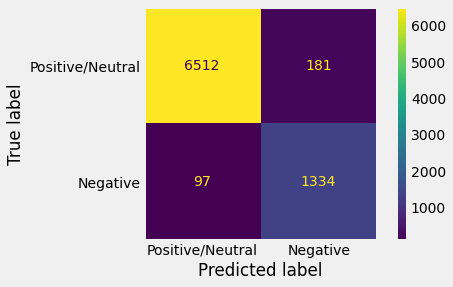

In [631]:
plt.style.use('fivethirtyeight')
ConfusionMatrixDisplay.from_predictions(y_train,y_pred,display_labels=['Positive/Neutral','Negative'])
plt.grid(False)
plt.show()

In [632]:
print(fn.classification_report(y_train,y_pred))


              precision    recall  f1-score   support

           0       0.99      0.97      0.98      6693
           1       0.88      0.93      0.91      1431

    accuracy                           0.97      8124
   macro avg       0.93      0.95      0.94      8124
weighted avg       0.97      0.97      0.97      8124



Compared to the conventional models, this model did a great job on recall for the negative class that is sought after, but the precision score is troubling, another model iteration needs to address this.

#### First Evaluation Validation

##### Transforming with Tokenizer

In [633]:
#Tokenizing on the validation Set
X_val_tokens = token.texts_to_sequences(X_val)
#Creating the validation sequences
val_seq = pad_sequences(X_val_tokens,maxlen=40)

In [634]:
#Predicting on validation Set
val_pred = model.predict(val_seq)
y_val_pred = [1 * (x[0]>=0.5) for x in val_pred]

32/32 [==============================] - 5s 166ms/step


In [635]:
print(fn.classification_report(y_val,y_val_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       836
           1       0.81      0.75      0.78       179

    accuracy                           0.92      1015
   macro avg       0.88      0.86      0.87      1015
weighted avg       0.92      0.92      0.92      1015



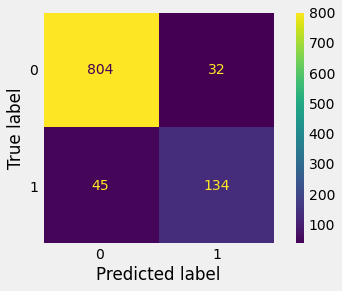

In [636]:
plt.style.use('fivethirtyeight')
ConfusionMatrixDisplay.from_predictions(y_val,y_val_pred)
plt.grid(False)
plt.show()

This is a mixed bag of evaluation. The neural network does appear to be slightly overfitting, but a bigger problem is the struggle with precision for the model. The model is struggling to separate positive from negative, the cases of very negative may be very clear to the model, but it's performance could indeed be better.

In [638]:
plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='test')
plt.legend()
plt.show()

KeyError: 'recall'

In [639]:
plt.plot(history.history['precision'], label='train')
plt.plot(history.history['val_precision'], label='test')
plt.legend()
plt.show()

KeyError: 'precision'

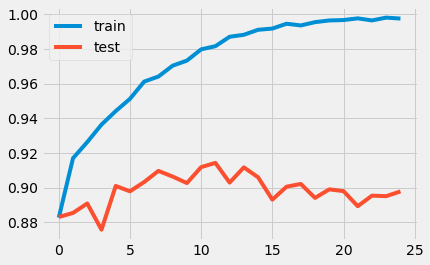

In [625]:
plt.plot(history.history['AUC'], label='train')
plt.plot(history.history['val_AUC'], label='test')
plt.legend()
plt.show()

Frustratingly the above charts reveal the difficulty with training epochs, as the 4th epoch was the highest validation score of recall, but the lowest for precision. I need to find a way to have the scores match better.

### Second LSTM Model

For this second model I am using the an fbeta score function, using a beta of 1.75, leaning more towards recall than precision as the last LSTM model showed a unacceptably low precision score. The fbeta score will be the determining metric for the early stopping on this model iteration.

In [626]:
from keras import backend as K
THRESHOLD = 0.5

def fbeta(y_true, y_pred, beta = 1.75, threshold_shift=0.5-THRESHOLD):   
    # just in case 
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall) 


In [627]:
model=Sequential()
model.add(Embedding(vocab_size,50,weights=[embedding_matrix],input_length=40,trainable=False))
model.add(Bidirectional(LSTM(units=64)))
model.add(Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=fbeta,run_eagerly=True)
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 40, 50)            474350    
                                                                 
 bidirectional_24 (Bidirecti  (None, 128)              58880     
 onal)                                                           
                                                                 
 dense_43 (Dense)            (None, 64)                8256      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_44 (Dense)            (None, 1)                 65        
                                                                 
Total params: 541,551
Trainable params: 67,201
Non-trainable params: 474,350
__________________________________________

In [628]:
es = EarlyStopping(monitor='val_fbeta', mode='max', verbose=1,patience=5,restore_best_weights=True,baseline=)


In [629]:
history = model.fit(train_seq,y_train,epochs = 100,batch_size=32,validation_split=0.2,class_weight=class_weight,callbacks=[es])

Epoch 1/100
204/204 [==============================] - 119s 579ms/step - loss: 0.4118 - fbeta: 0.6769 - val_loss: 0.2654 - val_fbeta: 0.6974
Epoch 2/100
204/204 [==============================] - 94s 459ms/step - loss: 0.3114 - fbeta: 0.7450 - val_loss: 0.3547 - val_fbeta: 0.6855
Epoch 3/100
204/204 [==============================] - 119s 583ms/step - loss: 0.2946 - fbeta: 0.7481 - val_loss: 0.2977 - val_fbeta: 0.6840
Epoch 4/100
204/204 [==============================] - 125s 616ms/step - loss: 0.2764 - fbeta: 0.7479 - val_loss: 0.2838 - val_fbeta: 0.7139
Epoch 5/100
204/204 [==============================] - 146s 716ms/step - loss: 0.2563 - fbeta: 0.7674 - val_loss: 0.2618 - val_fbeta: 0.6912
Epoch 6/100
204/204 [==============================] - 127s 622ms/step - loss: 0.2393 - fbeta: 0.7878 - val_loss: 0.2872 - val_fbeta: 0.7124
Epoch 7/100
204/204 [==============================] - 80s 392ms/step - loss: 0.2331 - fbeta: 0.7936 - val_loss: 0.2743 - val_fbeta: 0.7107
Epoch 8/100
204

In [640]:
predict = model.predict(train_seq)
y_pred = [1 * (x[0]>=0.5) for x in predict]

254/254 [==============================] - 38s 150ms/step


In [641]:
print(fn.classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      6693
           1       0.88      0.93      0.91      1431

    accuracy                           0.97      8124
   macro avg       0.93      0.95      0.94      8124
weighted avg       0.97      0.97      0.97      8124



In [642]:
predict = model.predict(val_seq)
y_val_pred = [1 * (x[0]>=0.5) for x in predict]

32/32 [==============================] - 5s 148ms/step


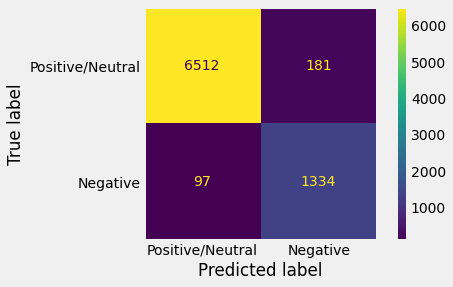

In [643]:
plt.style.use('fivethirtyeight')
ConfusionMatrixDisplay.from_predictions(y_train,y_pred,display_labels=['Positive/Neutral','Negative'])
plt.grid(False)
plt.show()

In [644]:
print(fn.classification_report(y_val,y_val_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       836
           1       0.81      0.75      0.78       179

    accuracy                           0.92      1015
   macro avg       0.88      0.86      0.87      1015
weighted avg       0.92      0.92      0.92      1015



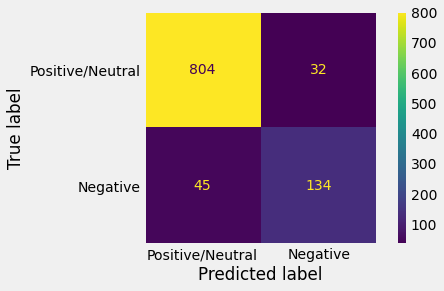

In [645]:
plt.style.use('fivethirtyeight')
ConfusionMatrixDisplay.from_predictions(y_val,y_val_pred,display_labels=['Positive/Neutral','Negative'])
plt.grid(False)
plt.show()

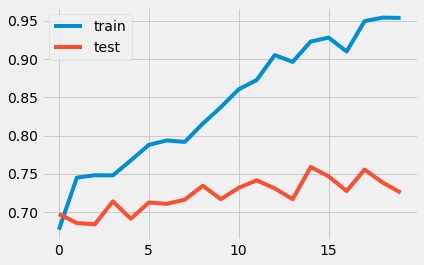

In [646]:
plt.plot(history.history['fbeta'], label='train')
plt.plot(history.history['val_fbeta'], label='test')
plt.legend()
plt.show()

### Third Model Iteration

For this third iteration I have added another LSTM layer. There is a 10% dropout. I am allowing a 10 of patience for the early stopping this time and increasing the epochs to 200, yes it's a lot of epochs, but the early stopping will prevent extensive overfitting.

In [647]:
model=Sequential()
model.add(Embedding(vocab_size,50,weights=[embedding_matrix],input_length=40,trainable=False))
model.add(Bidirectional(LSTM(128,return_sequences=True,)))
model.add(Dense(256, activation='relu'))
model.add(Bidirectional(LSTM(64)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=fbeta,run_eagerly=True)
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 40, 50)            474350    
                                                                 
 bidirectional_25 (Bidirecti  (None, 40, 256)          183296    
 onal)                                                           
                                                                 
 dense_45 (Dense)            (None, 40, 256)           65792     
                                                                 
 bidirectional_26 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_46 (Dense)            (None, 64)              

In [648]:
es = EarlyStopping(monitor='val_fbeta', mode='max', verbose=1,patience=10,restore_best_weights=True)


In [649]:
history = model.fit(train_seq,y_train,epochs = 200,batch_size=32,validation_split=0.2,class_weight=class_weight,callbacks=[es])

Epoch 1/200
204/204 [==============================] - 250s 1s/step - loss: 0.4011 - fbeta: 0.6924 - val_loss: 0.2892 - val_fbeta: 0.6870
Epoch 2/200
204/204 [==============================] - 280s 1s/step - loss: 0.3244 - fbeta: 0.7193 - val_loss: 0.3467 - val_fbeta: 0.6829
Epoch 3/200
204/204 [==============================] - 215s 1s/step - loss: 0.3057 - fbeta: 0.7440 - val_loss: 0.2703 - val_fbeta: 0.6984
Epoch 4/200
204/204 [==============================] - 266s 1s/step - loss: 0.2880 - fbeta: 0.7455 - val_loss: 0.2503 - val_fbeta: 0.7041
Epoch 5/200
204/204 [==============================] - 346s 2s/step - loss: 0.2738 - fbeta: 0.7659 - val_loss: 0.2748 - val_fbeta: 0.7169
Epoch 6/200
204/204 [==============================] - 459s 2s/step - loss: 0.2633 - fbeta: 0.7703 - val_loss: 0.2787 - val_fbeta: 0.7155
Epoch 7/200
204/204 [==============================] - 404s 2s/step - loss: 0.2333 - fbeta: 0.7897 - val_loss: 0.3433 - val_fbeta: 0.6969
Epoch 8/200
204/204 [=============

In [651]:
history.history.keys()

dict_keys(['loss', 'fbeta', 'val_loss', 'val_fbeta'])

In [652]:
predict = model.predict(val_seq)
y_val_pred = [1 * (x[0]>=0.5) for x in predict]

32/32 [==============================] - 18s 540ms/step


In [653]:
print(fn.classification_report(y_val,y_val_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       836
           1       0.77      0.75      0.76       179

    accuracy                           0.92      1015
   macro avg       0.86      0.85      0.86      1015
weighted avg       0.92      0.92      0.92      1015



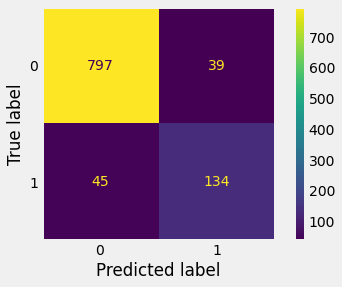

In [654]:
plt.style.use('fivethirtyeight')
ConfusionMatrixDisplay.from_predictions(y_val,y_val_pred)
plt.grid(False)
plt.show()

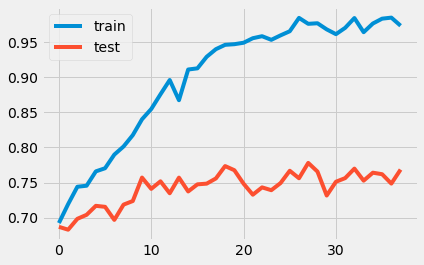

In [657]:
plt.plot(history.history['fbeta'], label='train')
plt.plot(history.history['val_fbeta'], label='test')
plt.legend()
plt.show()

### Final Model Selection

In [658]:
cross_val_scores = pd.read_csv('cross_val_scores')


In [659]:
val_scores = pd.read_csv('val_scores')

In [660]:
cross_val_scores

Unnamed: 0                                      Name  mean_accuracy  \
0            0                            Baseline Dummy       0.862207   
1            1                            Baseline Bayes       0.929264   
2            2                   Baseline Random Forrest       0.932274   
3            3                            Logistic_TFIDF       0.913545   
4            4                     Comp Bayes Added Negs       0.887739   
5            5                            Logistic_TFIDF       0.898662   
6            6                              Logistic_BOW       0.862876   
7            8                 Tuned Logistic Regression       0.867057   
8            7                            Logistic_TFIDF       0.867057   
9            9                                   Grid RF       0.708696   
10          10                         Baseline Logistic       0.829766   
11          11      Baseline Random Forrest_Add_Examples       0.946086   
12          12  Random Forrest Added Negs Halving Search       0.930206   
13          16     Random Forrest Added Negs Grid Search       0.905956   
14          13                     Comp Bayes Added Negs       0.908050   
15          14                Base Log Additional Tweets       0.926268   
16          15           Grid Logistic Additional Tweets       0.929345   

    std_accuracy  mean_precision  std_precision  mean_recall  std_recall  \
0       0.006315        0.064903       0.026349     0.073583    0.041059   
1       0.002727        0.614499       0.087212     0.144994    0.028733   
2       0.002828        0.685464       0.112174     0.165069    0.026619   
3       0.009138        0.395436       0.086763     0.299001    0.072966   
4       0.004822        0.975987       0.014207     0.371740    0.025968   
5       0.006983        0.357625       0.031299     0.437453    0.025999   
6       0.006099        0.285229       0.022435     0.553308    0.062936   
7       0.004164        0.300116       0.021531     0.584544    0.057838   
8       0.004164        0.300116       0.021531     0.584544    0.057838   
9       0.018543        0.159990       0.014757     0.611486    0.040402   
10      0.008388        0.245816       0.022980     0.615780    0.062758   
11      0.004060        0.966228       0.008064     0.719749    0.021266   
12      0.010962        0.867595       0.030344     0.736517    0.032800   
13      0.006357        0.789615       0.072529     0.779153    0.030265   
14      0.008261        0.714311       0.023215     0.797315    0.026714   
15      0.003799        0.787183       0.014182     0.797329    0.020037   
16      0.004527        0.793723       0.017728     0.809902    0.019774   

     mean_f1    std_f1                            notes  
0   0.069426  0.015259                              NaN  
1   0.234251  0.043402                              NaN  
2   0.260588  0.042885                              NaN  
3   0.339969  0.078817                       N_grams2,2  
4   0.537941  0.028075                              NaN  
5   0.393250  0.028001                       N_grams1,2  
6   0.376122  0.032752                      N_Grams_1,2  
7   0.396524  0.032114                              NaN  
8   0.396524  0.032114                       N_grams1,1  
9   0.248804  0.013385       Grid Search Random Forrest  
10  0.351303  0.033441  Balanced Weights/Ngrams 1,1,BoW  
11  0.824321  0.016022                              NaN  
12  0.778151  0.028528                              NaN  
13  0.742281  0.031362                              NaN  
14  0.753355  0.022040                              NaN  
15  0.792012  0.011487                              NaN  
16  0.801488  0.012629                              NaN

In [661]:
val_scores

Unnamed: 0                                           Name  accuracy  \
0           0                                    Baseline CB  0.926471   
1           1                                Tune Comp Bayes  0.840909   
2           2                                 Tuned Logistic  0.827540   
3           6  Random Forrest Added Negs Halving Grid Search  0.923153   
4           3                     Grid Search Random Forrest  0.673797   
5           4                Grid Logistic Addtiional Tweets  0.922167   
6           5                     Tuned Comp Bayes Added Neg  0.915271   

   precision    recall        f1  notes  
0   0.538462  0.125000  0.202899    NaN  
1   0.259542  0.607143  0.363636    NaN  
2   0.248276  0.642857  0.358209    NaN  
3   0.838926  0.698324  0.762195    NaN  
4   0.151852  0.732143  0.251534    NaN  
5   0.780899  0.776536  0.778711    NaN  
6   0.740933  0.798883  0.768817    NaN

In [5]:
import pickle


In [38]:
LG_GS_Neg = pickle.load(open('final_logistic.sav', 'rb'))


In [75]:
X_val= pd.DataFrame(token_docs,columns=['processed_text'])
X_val.set_index(y.index,inplace=True)
X_val = X['processed_text']

NameError: name 'token_docs' is not defined

In [95]:
X_val = X_val.str.join(' ')

In [50]:
X_val

1402    startups free premium service one st job post ...
4801    umm hello android rt awesome new version iphon...
2356                    congrats iphone app featured sxsw
1484    like bad rt sitting bar listening music w thre...
2427    uber brand smart going move ton ipad two apple...
                              ...                        
9176                 lol iphone weak get lumia level bruh
1499    hmm cannot get twitter searches update hootsui...
3291    abba gotten dissed two sxsw panels row love mu...
9119    l school district officially ends one three bi...
2211    sxsw ballroom one seat reserved fourth row any...
Name: processed_text, Length: 1015, dtype: object

In [272]:
LG_GS_Neg.best_params_

{'clf__C': 10,
 'clf__class_weight': 'balanced',
 'tfidf__max_df': 0.9,
 'tfidf__ngram_range': (1, 1),
 'tfidf__use_idf': False}

In [273]:
y_val

1402    0
4801    0
2356    0
1484    0
2427    0
       ..
9176    1
1499    1
3291    0
9119    1
2211    0
Name: Sentiment, Length: 1015, dtype: uint8

In [98]:
X_val

1402    startups free premium service one st job post ...
4801    umm hello android rt awesome new version iphon...
2356                    congrats iphone app featured sxsw
1484    like bad rt sitting bar listening music w thre...
2427    uber brand smart going move ton ipad two apple...
                              ...                        
9176                 lol iphone weak get lumia level bruh
1499    hmm cannot get twitter searches update hootsui...
3291    abba gotten dissed two sxsw panels row love mu...
9119    l school district officially ends one three bi...
2211    sxsw ballroom one seat reserved fourth row any...
Name: processed_text, Length: 1015, dtype: object

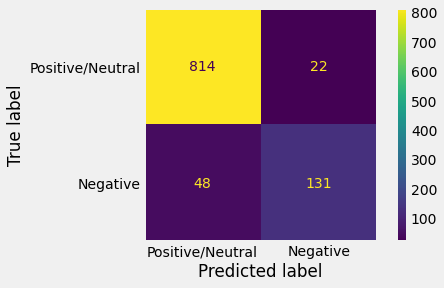

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       836
           1       0.86      0.73      0.79       179

    accuracy                           0.93      1015
   macro avg       0.90      0.85      0.87      1015
weighted avg       0.93      0.93      0.93      1015



In [97]:
fn.reporting(LG_GS_Neg.best_estimator_,X_val,y_val)

Compare this to the report from the final neural network - 

In [93]:
print(fn.classification_report(y_val,y_val_pred))

NameError: name 'y_val_pred' is not defined

#### Testing Model on Test Data

In [70]:
fn.reporting(LG_GS_Neg.best_estimator_,X_test,y_test)


AttributeError: 'list' object has no attribute 'lower'

The final model I am choosing is a tuned logistic regression model using a TFIDF vectorization and unigrams. Intuitively I want to use bigrams, as I do think the EDA revealed some interesting phrases, but there were better scores without them. The neural networks were almost as a good as the logistic regression model, but, I the cross-validation scores were consistent with the scores on the validation set. I trust this model the most because I have scored this model thoroughly. There were decision points that gave me pause, but there is enough in the dataset that pushed me towrads this model.

#### Model Interpretation

In [813]:
coeffecients = LG_GS_Neg.best_estimator_.steps[1][1].coef_.flatten()
feature_names = LG_GS_Neg.best_estimator_.steps[0][1].get_feature_names_out()

In [1060]:
from re import sub

In [1061]:
def replace_content(dict_replace, target):
    """Based on dict, replaces key with the value on the target."""

    for check, replacer in list(dict_replace.items()):
        target = sub(check, replacer, target)
        # target = target.replace(check, replacer)

    return target


# check : replacer
dict_replace = {
    'fuck': 'f*ck',
    'cunt,': 'c*nt',
    'fucking': 'f*cking',
    'shit':'sh!t',
    'asshole':'a$$h*le',
}

In [1062]:
zipped = zip(feature_names,coeffecients)
coef_df = pd.DataFrame(zipped, columns=['feature', 'value'])
coef_df["abs_value"] = coef_df["value"].apply(lambda x: abs(x))
coef_df = coef_df.sort_values("abs_value", ascending=False)
coef_df["colors"] = coef_df["value"].apply(lambda x: "red" if x > 0 else "blue")

In [1073]:
coef_df['feature'][7163]

'shit'

In [1079]:
coef_df['feature'] = coef_df['feature'].map(lambda x: (replace_content(dict_replace,x)))

In [1080]:
top_coef = coef_df.head(15)

Text(0.5, 0, 'Features')

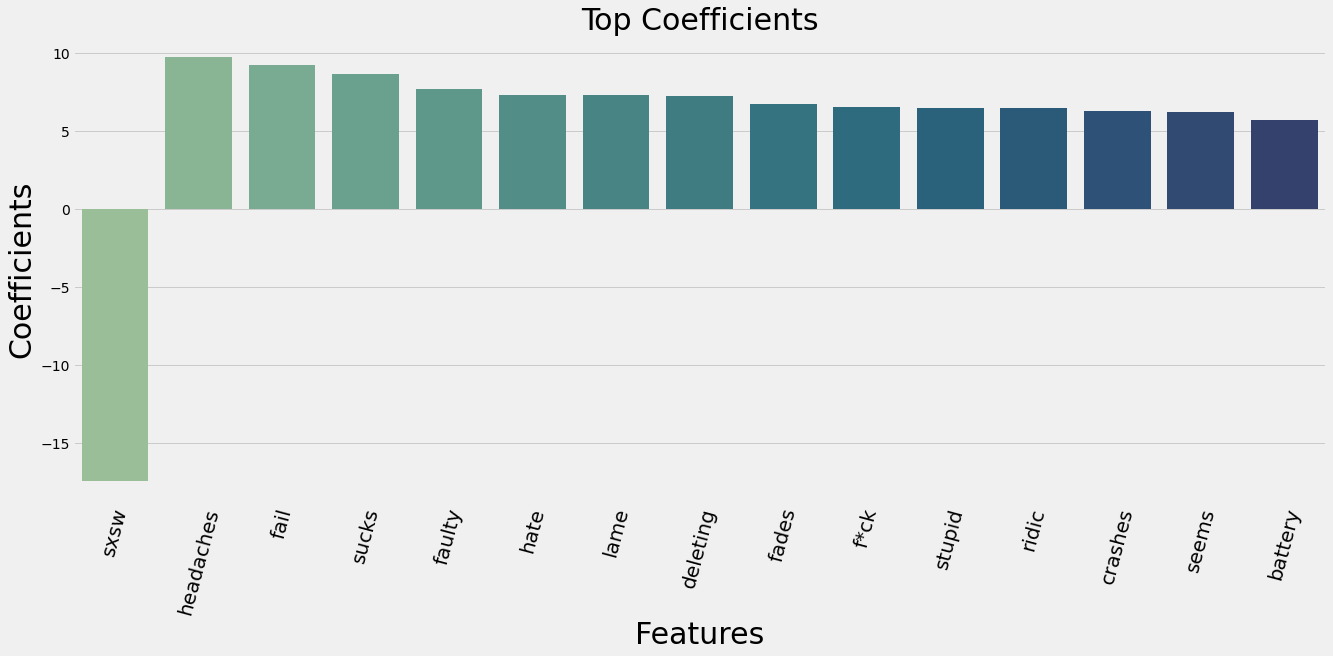

In [1081]:
fig, ax = plt.subplots(figsize=(20,8))
plt.xticks(rotation=75)
plt.xticks(size=20)
ax.set_title('Top Coefficients',size=30)
sns.barplot(data=top_coef,x='feature',y='value',palette='crest')
ax.set_ylabel('Coefficients',size=30)
ax.set_xlabel('Features',size=30)

In [1082]:
top_15= coef_df.sort_values(by='abs_value',ascending=False).head(15)
top_poz_coef_10 = coef_df[coef_df['value']<0].head(10)
top_neg_coef_10 = coef_df[coef_df['value']>0].head(10)

In [1083]:
top_neg_coef_10

feature     value  abs_value colors
3673  headaches  9.780112  9.780112   red  
2829  fail       9.239606  9.239606   red  
7764  sucks      8.696747  8.696747   red  
2886  faulty     7.706158  7.706158   red  
3642  hate       7.341673  7.341673   red  
4501  lame       7.318396  7.318396   red  
2030  deleting   7.263459  7.263459   red  
2826  fades      6.754077  6.754077   red  
3204  f*ck       6.521560  6.521560   red  
7739  stupid     6.455944  6.455944   red

Text(0.5, 0, 'Features')

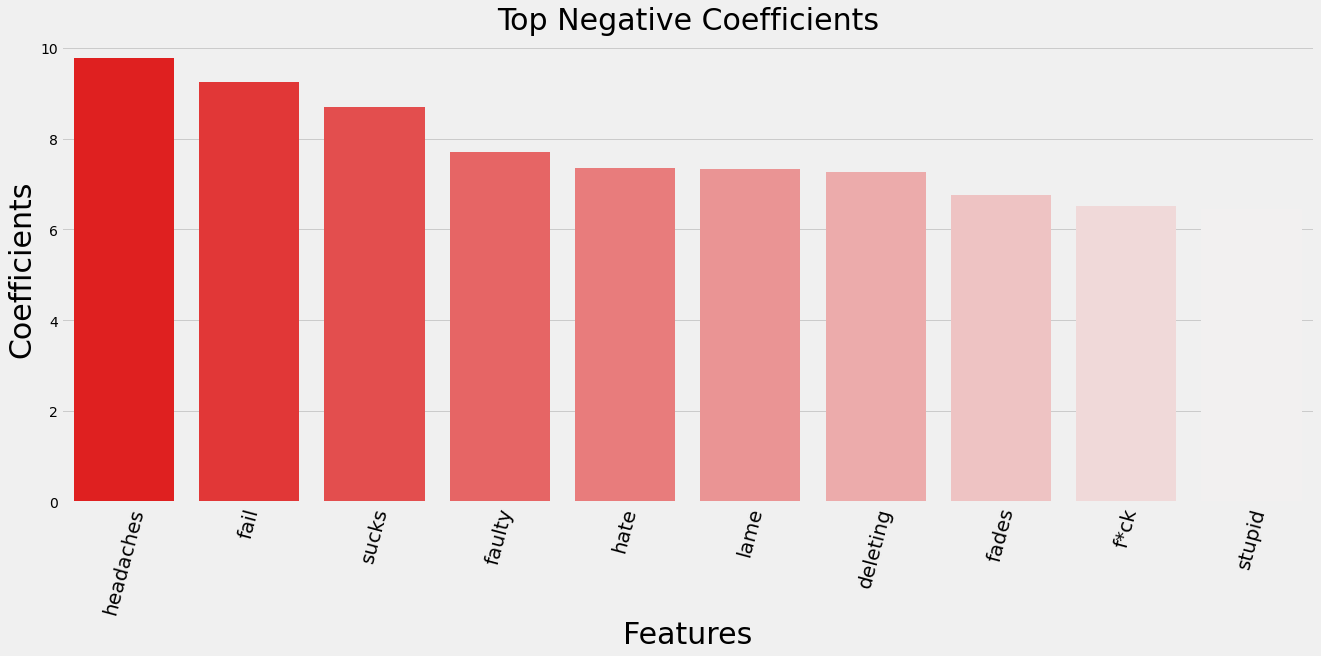

In [1084]:
fig, ax = plt.subplots(figsize=(20,8))
plt.xticks(rotation=75)
plt.xticks(size=20)
ax.set_title('Top Negative Coefficients',size=30)
sns.barplot(data=top_neg_coef_10,x='feature',y='value',palette='light:r_r')
ax.set_ylabel('Coefficients',size=30)
ax.set_xlabel('Features',size=30)

Text(0.5, 0, 'Features')

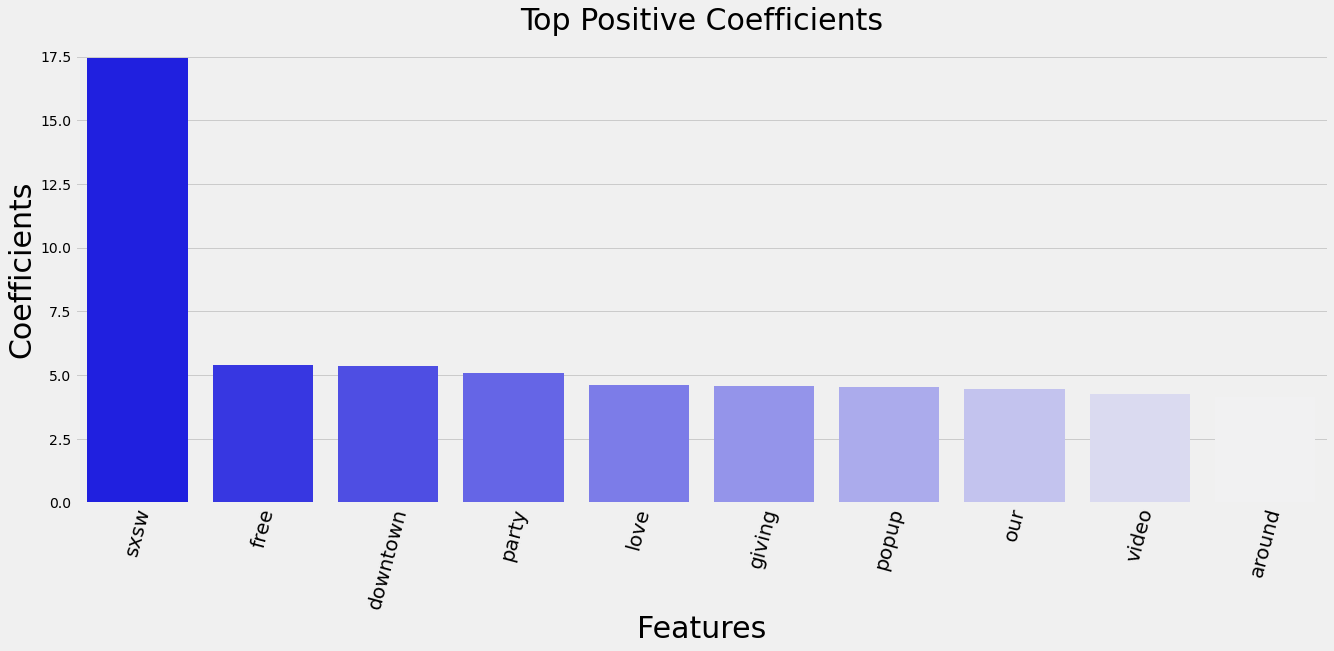

In [1085]:
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=top_poz_coef_10,x='feature',y='abs_value',palette="light:b_r")
ax.set_title('Top Positive Coefficients',size=30)
ax.tick_params(axis='x', labelrotation = 75,labelsize=20)
ax.set_ylabel('Coefficients',size=30)
ax.set_xlabel('Features',size=30)





In [793]:
np.sum(coef_df['value']>0)

2556

In [794]:
np.sum(coef_df['value']<0)

6676

There are far more positive coefficients than negative coefficients, the negative coefficients appear to have a larger affect on the prediction.

#### ROC Curve

In [989]:
y_pred_prob = LG_GS_Neg.best_estimator_.predict_proba(X_test)
lr_probs = y_pred_prob[:, 1]

In [990]:
lr_probs

array([0.0212042 , 0.00172895, 0.51685219, ..., 0.05344573, 0.00902241,
       0.04519285])

In [991]:
ns_probs = [0 for _ in range(len(y_test))]

In [992]:
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

In [993]:
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.958


In [994]:
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

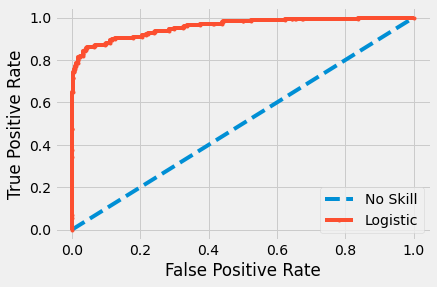

In [995]:
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

#### Word Clouds Based on Brands

In [1361]:
coef_df

feature      value  abs_value colors
7872  sxsw         -17.437448  17.437448  blue 
3673  headaches     9.780112   9.780112   red  
2829  fail          9.239606   9.239606   red  
7764  sucks         8.696747   8.696747   red  
2886  faulty        7.706158   7.706158   red  
...      ...             ...        ...   ...  
1311  chavez       -0.000325   0.000325   blue 
7870  sxsma        -0.000299   0.000299   blue 
8225  tipb         -0.000290   0.000290   blue 
8011  team_android -0.000118   0.000118   blue 
6707  retailers    -0.000091   0.000091   blue 

[9232 rows x 4 columns]

In [1364]:
new_df[new_df['Product']=='Apple']

tweet_text  \
8      Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear                                                           
39     @mention  - Great weather to greet you for #sxsw! Still need a sweater at night..Apple putting up &quot;flash store&quot; downtown to sell iPad2   
46     HOORAY RT @mention Apple Is Opening A Pop-Up Store In Austin For #SXSW | @mention {link}                                                           
48     wooooo!!! @mention Apple store downtown Austin open til Midnight. #sxsw۝                                                                           
61     #OMFG! RT @mention Heard about Apple's pop-up store in downtown Austin? Pics are already on Gowalla: {link} #sxsw #iPad2                           
...                                                                                                                         ...                           
10150  RT @Ecofantasy: Thinking of upgrading to #Yosemite? Think twice  http://t.co/dU0Mpaw5Ri It's not for everyone. RT #ASMSG @Apple                    
10151  why isnt group facetime a thing @apple wtf                                                                                                         
10152  Being held hostage at @apple - They are replacing the whole phone. Last backup at 630 a.m. this morning so anything since was byebyebye.           
10153  hey @apple is it normal for my laptop charger to be soldering itself to my skin? Thanks! - J                                                       
10154  My iPhone 5's photos are no longer downloading automatically to my laptop when I sync it. @apple support is unhelpful. Any ideas?                  

      Product  Sentiment  \
8      Apple   0           
39     Apple   0           
46     Apple   0           
48     Apple   0           
61     Apple   0           
...      ...  ..           
10150  Apple   1           
10151  Apple   1           
10152  Apple   1           
10153  Apple   1           
10154  Apple   1           

                                                                                                                                                processed_text  
8      Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear                                                                 
39       - Great weather to greet you for #sxsw! Still need a sweater at night..Apple putting up "flash store" downtown to sell iPad two                        
46     HOORAY RT  Apple Is Opening A Pop-Up Store In Austin For #SXSW |                                                                                         
48     wooooo!!!  Apple store downtown Austin open til Midnight. #sxsw                                                                                          
61     OMFG! RT  Heard about Apple's pop-up store in downtown Austin? Pics are already on Gowalla:  #sxsw #iPad two                                             
...                                                                                                              ...                                            
10150  RT : Thinking of upgrading to #Yosemite? Think twice    It is not for everyone. RT #ASMSG                                                                
10151  why is not group facetime a thing  wtf                                                                                                                   
10152  Being held hostage at  - They are replacing the whole phone. Last backup at  six hundred and thirty  a.m. this morning so anything since was byebyebye.  
10153  hey  is it normal for my laptop charger to be soldering itself to my skin? Thanks! - J                                                                   
10154  My iPhone  five 's photos are no longer downloading automatically to my laptop when I sync it.  support is unhelpful. Any ideas?                         

[1878 rows

In [ ]:
new_df[new_df['Product']=='Apple']

In [1381]:
vectorizer.transform(new_df[new_df['Product']=='Apple']['processed_text'])

<1878x9232 sparse matrix of type '<class 'numpy.float64'>'
	with 26912 stored elements in Compressed Sparse Row format>

In [ ]:
bag_of_words = vectorizer.transform(new_df[new_df['Product']=='Google']['processed_text'])


#### Function to Get Frequencies to Plot

In [1631]:
def get_brand_frequencies(data,brand,model,sentiment):
    #set corpus as overall dataset
    corpus = data['processed_text']
    #fit vectorizer on corpus
    vectorizer = TfidfVectorizer(ngram_range=(1,1),use_idf=False,max_df=.9)
    vectorizer.fit_transform(corpus)
    #Transform on specific brand
    bag_of_words = vectorizer.transform(data[data['Product']==brand]['processed_text'])
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    #Create word frequencies 
    brand_frame = pd.DataFrame(words_freq,columns=['Word','Frequency'])
    brand_frame['Probability']=brand_frame['Word'].map(lambda x: model.best_estimator_.predict_proba([x]))
    brand_frame['Negative']=brand_frame['Probability'].map(lambda x: x[0][1])
    brand_frame['Positive']=brand_frame['Probability'].map(lambda x: x[0][0])
    sorted_frame = brand_frame.sort_values(by=sentiment,ascending=False)[0:200]
    sorted_frame['Word'] = sorted_frame['Word'].map(lambda x: (replace_content(dict_replace,x)))
    sorted_frame[['Word','Frequency']][0:200]
    dictionary = dict(zip(sorted_frame.Word, sorted_frame.Frequency))
    return dictionary

#### Word Clouds for Products

In [1556]:
LG_GS_Neg.best_estimator_.classes_

array([0, 1], dtype=uint8)

In [1632]:
Apple_Neg_freq = get_brand_frequencies(new_df,'Apple',LG_GS_Neg,sentiment='Negative')
Apple_Poz_freq = get_brand_frequencies(new_df,'Apple',LG_GS_Neg,sentiment='Positive')

In [1592]:
iPad_Neg_freq = get_brand_frequencies(new_df,'iPad',LG_GS_Neg,sentiment='Negative')
iPad_Poz_freq = get_brand_frequencies(new_df,'iPad',LG_GS_Neg,sentiment='Positive')

In [1593]:
Google_Neg_freq = get_brand_frequencies(new_df,'Google',LG_GS_Neg,sentiment='Negative')
Google_Poz_freq = get_brand_frequencies(new_df,'Google',LG_GS_Neg,sentiment='Positive')

In [1627]:
iPhone_Neg_freq = get_brand_frequencies(new_df,'iPhone',LG_GS_Neg,sentiment='Negative')
iPhone_Poz_freq = get_brand_frequencies(new_df,'iPhone',LG_GS_Neg,sentiment='Positive')

In [1591]:
new_df['Product'].value_counts(normalize=True)

Apple                              0.417241
iPad                               0.209287
iPad or iPhone App                 0.104421
Google                             0.095312
iPhone                             0.065763
Other Google product or service    0.064874
Android App                        0.017996
Android                            0.017329
Other Apple product or service     0.007776
Name: Product, dtype: float64

In [1512]:
apple_poz_freq = get_brand_frequencies(new_df,'Apple',LG_GS_Neg,sentiment='Positive')

In [1514]:
apple_poz_freq['party']

KeyError: 'party'

In [1633]:
Apple_Poz_freq = {key: Apple_Poz_freq[key] for key in Apple_Poz_freq if key not in sw}
Apple_Neg_freq = {key: Apple_Neg_freq[key] for key in Apple_Neg_freq if key not in sw}
Google_Poz_freq = {key: Google_Poz_freq[key] for key in Google_Poz_freq if key not in sw}
Google_Neg_freq = {key: Google_Neg_freq[key] for key in Google_Neg_freq if key not in sw}
iPad_Neg_freq = {key: iPad_Neg_freq[key] for key in iPad_Neg_freq if key not in sw}
iPad_Poz_freq = {key: iPad_Poz_freq[key] for key in iPad_Poz_freq if key not in sw}
iPhone_Poz_freq = {key: iPhone_Poz_freq[key] for key in iPhone_Poz_freq if key not in sw}
iPhone_Neg_freq = {key: iPhone_Neg_freq[key] for key in iPhone_Neg_freq if key not in sw}

In [1612]:
def display_cloud(dic,title,color):
    wc = WordCloud(stopwords=sw,width=1000, height=760,normalize_plurals=False,colormap=color).generate_from_frequencies(dic)
    plt.figure( figsize=(20,10))
    plt.imshow(wc)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [ ]:
display_cloud()

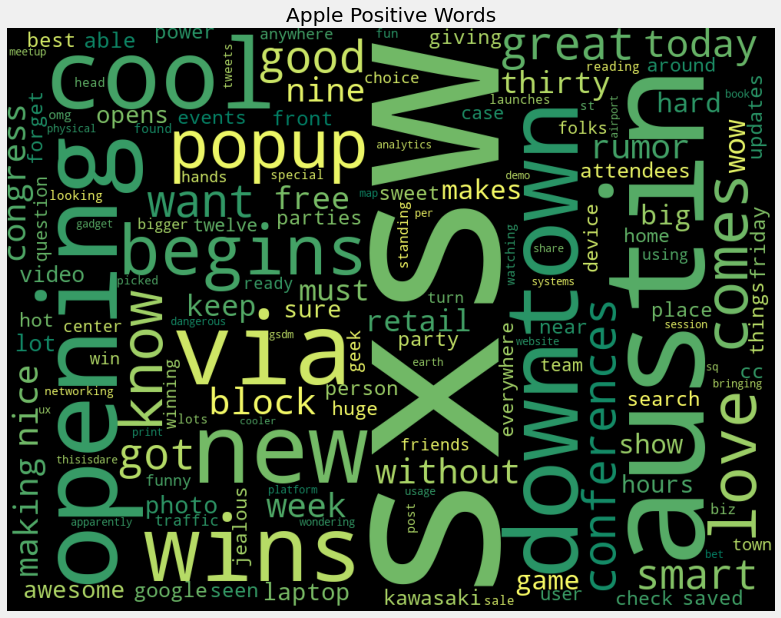

In [1615]:
display_cloud(Apple_Poz_freq,'Apple Positive Words',color='summer')

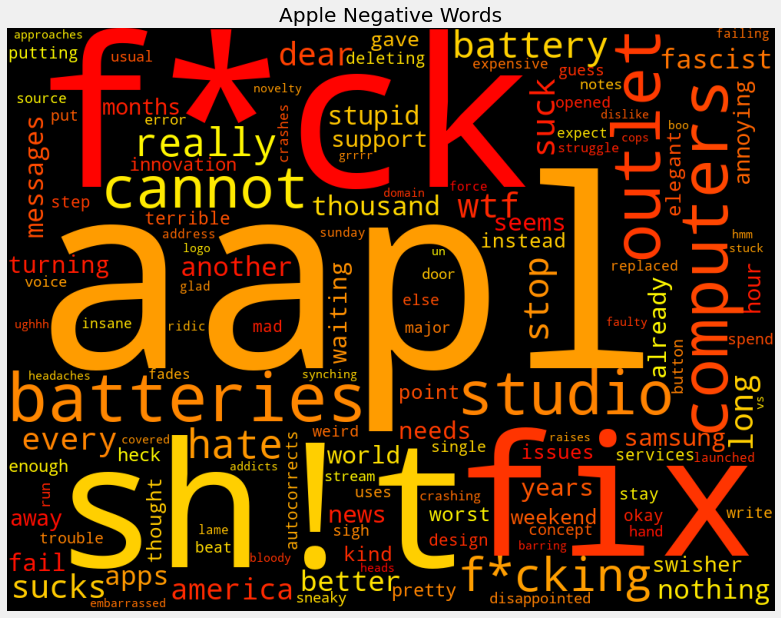

In [1634]:
display_cloud(Apple_Neg_freq,'Apple Negative Words',color='autumn')

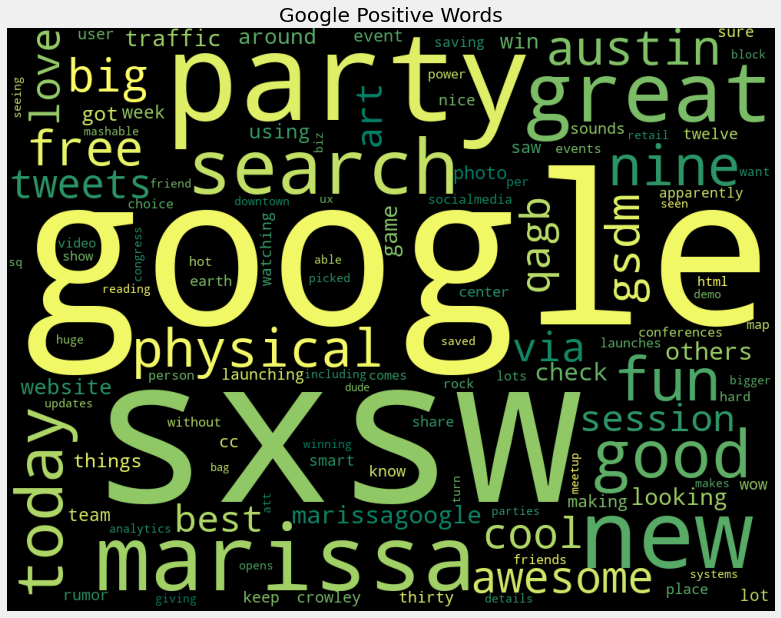

In [1635]:
display_cloud(Google_Poz_freq,'Google Positive Words',color='summer')

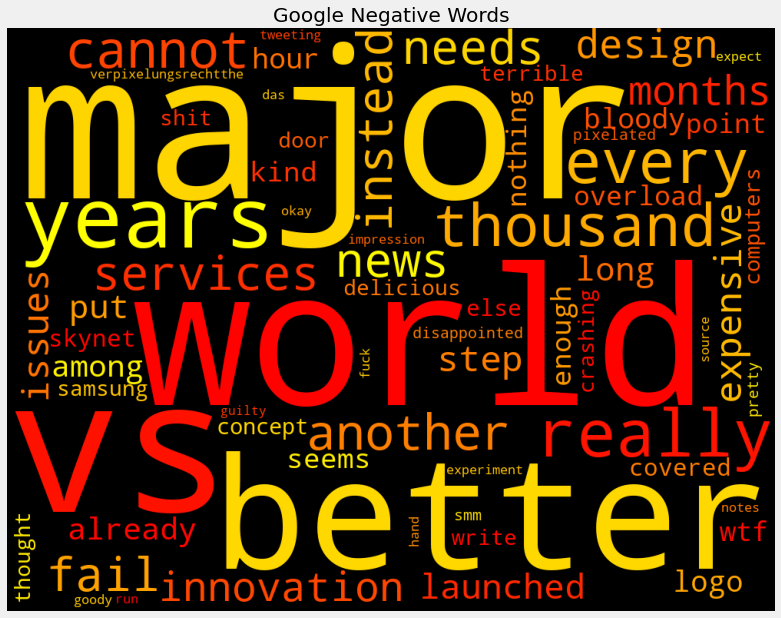

In [1636]:
display_cloud(Google_Neg_freq,'Google Negative Words',color='autumn')

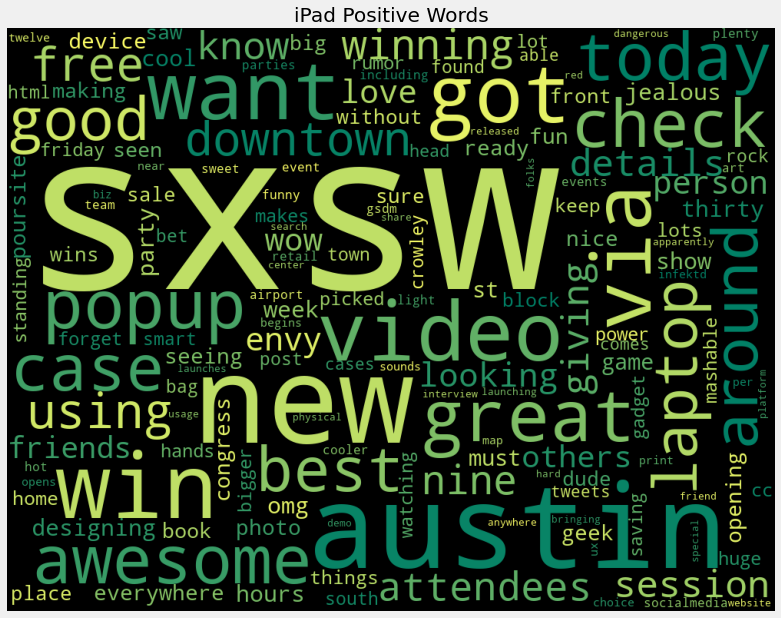

In [1637]:
display_cloud(iPad_Poz_freq,'iPad Positive Words',color='summer')

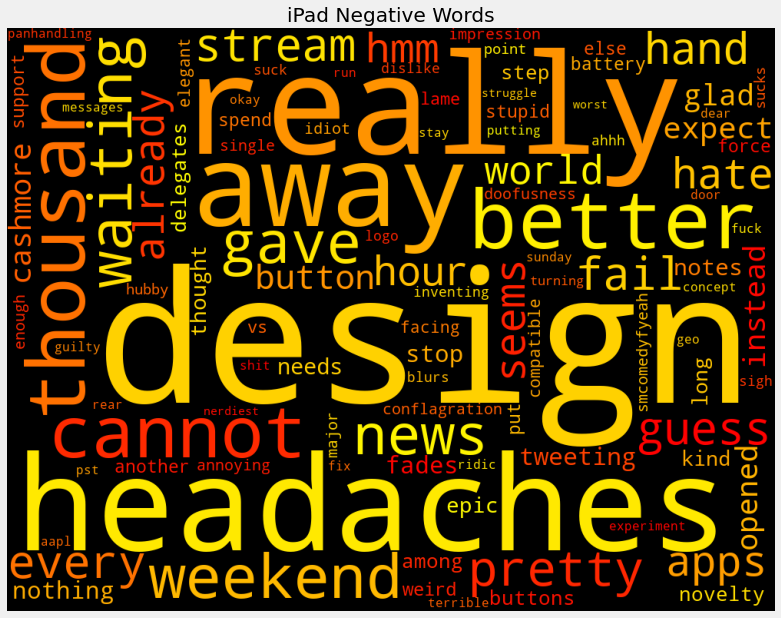

In [1638]:
display_cloud(iPad_Neg_freq,'iPad Negative Words',color='autumn')

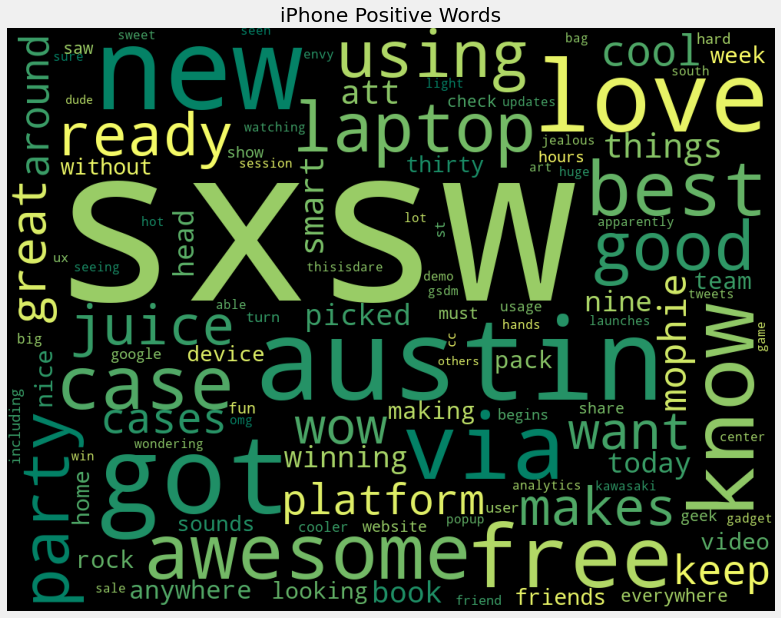

In [1629]:
display_cloud(iPhone_Poz_freq,'iPhone Positive Words',color='summer')

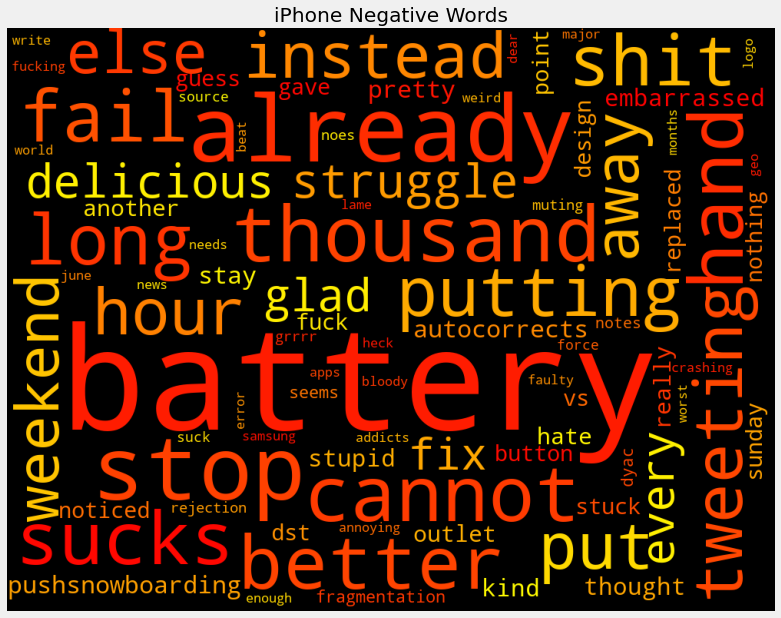

In [1630]:
display_cloud(iPhone_Neg_freq,'iPhone Negative Words',color='autumn')

In [1418]:
corpus = new_df['processed_text']
vectorizer = TfidfVectorizer(ngram_range=(1,1),use_idf=False,max_df=.9)
vectorizer.fit_transform(corpus)

<10155x10184 sparse matrix of type '<class 'numpy.float64'>'
	with 156305 stored elements in Compressed Sparse Row format>

In [ ]:
bag_of_words = vectorizer.transform(new_df[new_df['Product']=='Google']['processed_text'])
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in     vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
google_words_freq = words_freq



In [1443]:
get_brand_frequencies(new_df,'Apple')

TypeError: get_brand_frequencies() missing 2 required positional arguments: 'model' and 'sentiment'

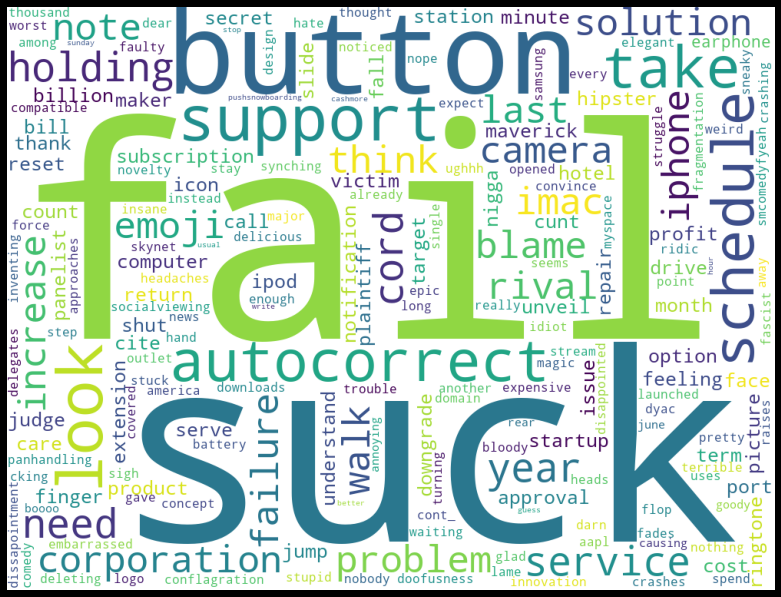

In [1501]:
sample_text = ' '.join(coef_df[coef_df['value']>0]['feature'])
wordcloud = WordCloud(min_word_length=4,max_words=200,width=1000, height=760, background_color="white",collocations=True).generate(sample_text)

# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

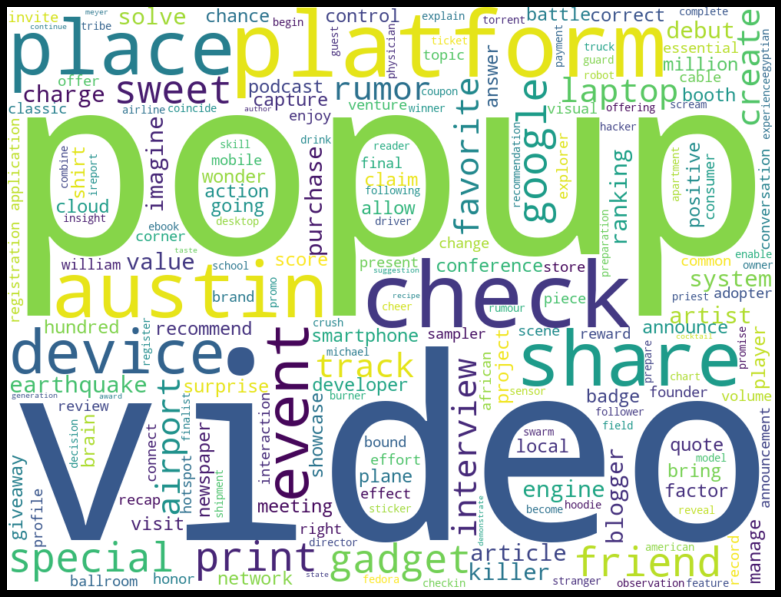

In [1089]:
sample_text = ' '.join(coef_df[coef_df['value']<0]['feature'])
wordcloud = WordCloud(min_word_length=5,max_words=200,width=1000, height=760, background_color="white",collocations=True).generate(sample_text)

# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [1036]:
coef_df[coef_df['feature'].str.contains('cker')]
\

feature     value  abs_value colors
6397      quicker  1.757714   1.757714    red
5960    pigf*cker  1.687108   1.687108    red
1403        ckers -0.985877   0.985877   blue
8314      tracker -0.682773   0.682773   blue
3571      hackers -0.460330   0.460330   blue
7656      sticker -0.412507   0.412507   blue
4458    knackered -0.364627   0.364627   blue
3570       hacker -0.287558   0.287558   blue
9226   zuckerberg  0.276564   0.276564    red
3695  heattracker -0.133002   0.133002   blue
7761      suckers  0.104006   0.104006    red
4461     knickers -0.097208   0.097208   blue
7657     stickers -0.084509   0.084509   blue
3043      flicker  0.084498   0.084498    red
58         ackers -0.069183   0.069183   blue
1402         cker -0.060550   0.060550   blue
7400     snackers -0.055938   0.055938   blue
4733      lockers -0.028333   0.028333   blue
3206       f*cker -0.017292   0.017292   blue
3572  hackerspace -0.011001   0.011001   blue

In [1037]:
def word_percentages(data,word):
    neg_occurances = np.sum(data[data['Sentiment']=='Negative']['lower_case'].str.contains(word))/np.sum(data['Sentiment']=='Negative')
    poz_occurances = np.sum(data[data['Sentiment']=='Positive']['lower_case'].str.contains(word))/np.sum(data['Sentiment']=='Positive')
    neutral_occurances = np.sum(data[data['Sentiment']=='Neutral']['lower_case'].str.contains(word))/np.sum(data['Sentiment']=='Neutral')
    return f'The word {word} appears {round(neg_occurances,4)}% of the negative portion of the dataset, {round(poz_occurances,4)} of the positive portion of the dataset, and {round(neutral_occurances,4)} of the neutral portion of the dataset.'

In [1044]:
pd.set_option('display.max_colwidth', 0)

In [1057]:
new_df[new_df['processed_text'].str.contains(' cker')]

tweet_text  \
349    Trying to balance the power of power needs on iPhone vs iPad at #sxsw. This 3G iPad sucks it out quick. Might have go airplane mode.                 
1268   Def could use an iPad for  #SXSW today. Tweeting via iPhone sorta pretty much sux.                                                                   
3155   Navigating a crowded party sucks. But its way worse when everyone walks around with their face in their iPhone. #sxsw #adpeopleproblems              
3261   @mention good job @mention #sxsw! went home &amp; watched season 1 of the guild =D. sucks that your tweet abt the iphone hijack is a top tweet lol   
4049   Dear google, your photobooth sucks. #sxsw                                                                                                            
4614   There at not even words for how much the wireless at #SXSW sucks.  Thank goodness for my iPhone.                                                     
7046   Looking forward to the day when @mention and @mention release native Android 3.0 tablet-optimized clients! Google Latitude sucks! #sxsw              
7322   Why the Apple pop-up shop at #SxSW sucks: {link}                                                                                                     
9027   Dear @apple replace my phone my battery sucks                                                                                                        
9028   RT @laurrynk: Dear @apple replace my phone my battery sucks                                                                                          
9030   RT @laurrynk: Dear @apple replace my phone my battery sucks                                                                                          
9217   @jakeflem @Apple That sucks, don't know what it cost in dollars but for us that was å£400 :(                                                         
9233   This new phone sucks I can't make it stand up or on its side I can't wait for the iPhone 7 @apple fix this you dingles                               
9244   RT @SaifBinS3eed: This new phone sucks I can't make it stand up or on its side I can't wait for the iPhone 7 @apple fix this you dingles             
9306   @Apple honestly sucks                                                                                                                                
9376   I could really kick @apple 's ass. This iPhone 6 battery sucks moldy dick on a Tuesday night ! Worst shit ever. Only last 4 fucking hours.           
9506   hey @apple why is my phone dying when it's on the charger \r\nur stuff sucks                                                                         
9624   RT @mrushh: hey @apple why is my phone dying when it's on the charger \r\nur stuff sucks                                                             
9629   dang this phone fuckin sucks. fuck you @apple!!! piece of shit iPhone man. y'all disappoint me.                                                      
9635   RT @mrushh: hey @apple why is my phone dying when it's on the charger \r\nur stuff sucks                                                             
9664   @daviddavidw @AugustSmartLock you know what #sucks ? @apple stores have had these locks weeks before many who preordered. #smh                       
9787   @yungshamwow @Apple apple sucks,                                                                                                                     
9838   @apple when are you going to fix the maps app. The navigation sucks!!! Face it and just switch to google maps.                                       
10018  my computer sux @apple fix it                                                                                                                        
10022  Apple sux '@TeamCavuto: Protesters stage protests in @Apple store in NYC... Is it me, or is this anger misplaced? RETWEET if you agree.'             
10047  @Apple airplay sucks on Yosemite                      

### Words Per Brand

In [1092]:
coef_df

feature      value  abs_value colors
7872  sxsw         -17.437448  17.437448  blue 
3673  headaches     9.780112   9.780112   red  
2829  fail          9.239606   9.239606   red  
7764  sucks         8.696747   8.696747   red  
2886  faulty        7.706158   7.706158   red  
...      ...             ...        ...   ...  
1311  chavez       -0.000325   0.000325   blue 
7870  sxsma        -0.000299   0.000299   blue 
8225  tipb         -0.000290   0.000290   blue 
8011  team_android -0.000118   0.000118   blue 
6707  retailers    -0.000091   0.000091   blue 

[9232 rows x 4 columns]

In [1158]:
coef_df.sort_values(by='abs_value',ascending=False).head(50)

feature      value  abs_value colors
7872  sxsw          -17.437448  17.437448  blue 
3673  headaches      9.780112   9.780112   red  
2829  fail           9.239606   9.239606   red  
7764  sucks          8.696747   8.696747   red  
2886  faulty         7.706158   7.706158   red  
3642  hate           7.341673   7.341673   red  
4501  lame           7.318396   7.318396   red  
2030  deleting       7.263459   7.263459   red  
2826  fades          6.754077   6.754077   red  
3204  f*ck           6.521560   6.521560   red  
7739  stupid         6.455944   6.455944   red  
6753  ridic          6.451623   6.451623   red  
1798  crashes        6.289040   6.289040   red  
7029  seems          6.253851   6.253851   red  
701   battery        5.737883   5.737883   red  
2322  doofusness     5.688485   5.688485   red  
1607  conflagration  5.688485   5.688485   red  
2873  fascist        5.446086   5.446086   red  
1583  concept        5.410954   5.410954   red  
3155  free          -5.389880   5.389880   blue 
2353  downtown      -5.345970   5.345970   blue 
735   because        5.260905   5.260905   red  
3597  hand           5.158327   5.158327   red  
1552  compatible     5.153794   5.153794   red  
4845  mad            5.143834   5.143834   red  
7723  stuck          5.136777   5.136777   red  
5345  needs          5.109446   5.109446   red  
3770  hm             5.105579   5.105579   red  
5795  party         -5.098910   5.098910   blue 
4232  issues         4.982983   4.982983   red  
6055  point          4.914137   4.914137   red  
4095  insane         4.907238   4.907238   red  
7163  sh!t           4.795971   4.795971   red  
316   another        4.792957   4.792957   red  
8394  trouble        4.718987   4.718987   red  
7929  synching       4.699373   4.699373   red  
4788  love          -4.629292   4.629292   blue 
1164  cannot         4.620345   4.620345   red  
3375  giving        -4.583598   4.583598   blue 
7433  socialviewing  4.545146   4.545146   red  
6088  popup         -4.529434   4.529434   blue 
7759  suck           4.518975   4.518975   red  
5660  our           -4.465675   4.465675   blue 
5758  panhandling    4.443292   4.443292   red  
2617  enough         4.438570   4.438570   red  
8067  terrible       4.402797   4.402797   red  
3208  f*cking        4.385420   4.385420   red  
7224  sigh           4.366568   4.366568   red  
7     aapl           4.358666   4.358666   red  
1103  button         4.343062   4.343062   red

In [1096]:
new_df[new_df['Product']=='Apple']


tweet_text  \
8      Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear                                                           
39     @mention  - Great weather to greet you for #sxsw! Still need a sweater at night..Apple putting up &quot;flash store&quot; downtown to sell iPad2   
46     HOORAY RT @mention Apple Is Opening A Pop-Up Store In Austin For #SXSW | @mention {link}                                                           
48     wooooo!!! @mention Apple store downtown Austin open til Midnight. #sxsw۝                                                                           
61     #OMFG! RT @mention Heard about Apple's pop-up store in downtown Austin? Pics are already on Gowalla: {link} #sxsw #iPad2                           
...                                                                                                                         ...                           
10150  RT @Ecofantasy: Thinking of upgrading to #Yosemite? Think twice  http://t.co/dU0Mpaw5Ri It's not for everyone. RT #ASMSG @Apple                    
10151  why isnt group facetime a thing @apple wtf                                                                                                         
10152  Being held hostage at @apple - They are replacing the whole phone. Last backup at 630 a.m. this morning so anything since was byebyebye.           
10153  hey @apple is it normal for my laptop charger to be soldering itself to my skin? Thanks! - J                                                       
10154  My iPhone 5's photos are no longer downloading automatically to my laptop when I sync it. @apple support is unhelpful. Any ideas?                  

      Product  Sentiment  \
8      Apple   0           
39     Apple   0           
46     Apple   0           
48     Apple   0           
61     Apple   0           
...      ...  ..           
10150  Apple   1           
10151  Apple   1           
10152  Apple   1           
10153  Apple   1           
10154  Apple   1           

                                                                                                                                                processed_text  
8      Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear                                                                 
39       - Great weather to greet you for #sxsw! Still need a sweater at night..Apple putting up "flash store" downtown to sell iPad two                        
46     HOORAY RT  Apple Is Opening A Pop-Up Store In Austin For #SXSW |                                                                                         
48     wooooo!!!  Apple store downtown Austin open til Midnight. #sxsw                                                                                          
61     OMFG! RT  Heard about Apple's pop-up store in downtown Austin? Pics are already on Gowalla:  #sxsw #iPad two                                             
...                                                                                                              ...                                            
10150  RT : Thinking of upgrading to #Yosemite? Think twice    It is not for everyone. RT #ASMSG                                                                
10151  why is not group facetime a thing  wtf                                                                                                                   
10152  Being held hostage at  - They are replacing the whole phone. Last backup at  six hundred and thirty  a.m. this morning so anything since was byebyebye.  
10153  hey  is it normal for my laptop charger to be soldering itself to my skin? Thanks! - J                                                                   
10154  My iPhone  five 's photos are no longer downloading automatically to my laptop when I sync it.  support is unhelpful. Any ideas?                         

[1878 rows

In [1105]:
tokenizer = lambda docs: [vectorizer.build_tokenizer()(doc) for doc in X_train]
corpus = ''.join(X_train)
corpus = [corpus]

In [1102]:
LG_GS_Neg.best_params_

{'clf__C': 10,
 'clf__class_weight': 'balanced',
 'tfidf__max_df': 0.9,
 'tfidf__ngram_range': (1, 1),
 'tfidf__use_idf': False}

In [1133]:
new_df

tweet_text  \
0      .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.               
1      @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2      @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                               
3      @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                            
4      @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)           
...                                                                                                                                    ...           
10150  RT @Ecofantasy: Thinking of upgrading to #Yosemite? Think twice  http://t.co/dU0Mpaw5Ri It's not for everyone. RT #ASMSG @Apple               
10151  why isnt group facetime a thing @apple wtf                                                                                                    
10152  Being held hostage at @apple - They are replacing the whole phone. Last backup at 630 a.m. this morning so anything since was byebyebye.      
10153  hey @apple is it normal for my laptop charger to be soldering itself to my skin? Thanks! - J                                                  
10154  My iPhone 5's photos are no longer downloading automatically to my laptop when I sync it. @apple support is unhelpful. Any ideas?             

                  Product  Sentiment  \
0      iPhone              1           
1      iPad or iPhone App  0           
2      iPad                0           
3      iPad or iPhone App  1           
4      Google              0           
...       ...             ..           
10150  Apple               1           
10151  Apple               1           
10152  Apple               1           
10153  Apple               1           
10154  Apple               1           

                                                                                                                                                processed_text  
0       I have a  three G iPhone. After  three  hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.                        
1       Know about  ? Awesome iPad/iPhone app that you will likely appreciate for its design. Also, they are giving free Ts at #SXSW                            
2       Can not wait for #iPad  two  also. They should sale them down at #SXSW.                                                                                 
3       I hope this year's festival is not as crashy as this year's iPhone app. #sxsw                                                                           
4       great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)                                    
...                                                                                                                      ...                                    
10150  RT : Thinking of upgrading to #Yosemite? Think twice    It is not for everyone. RT #ASMSG                                                                
10151  why is not group facetime a thing  wtf                                                                                                                   
10152  Being held hostage at  - They are replacing the whole phone. Last backup at  six hundred and thirty  a.m. this morning so anything since was byebyebye.  
10153  hey  is it normal for my laptop charger to be soldering itself to my skin? Thanks! - J                                                                   
10154  My iPhone  five 's photos are no longer downloading automatically to my lapt

In [1136]:
Apple_df = new_df[new_df['Product']=='Apple']


In [1137]:
Apple_df

tweet_text  \
8      Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear                                                           
39     @mention  - Great weather to greet you for #sxsw! Still need a sweater at night..Apple putting up &quot;flash store&quot; downtown to sell iPad2   
46     HOORAY RT @mention Apple Is Opening A Pop-Up Store In Austin For #SXSW | @mention {link}                                                           
48     wooooo!!! @mention Apple store downtown Austin open til Midnight. #sxsw۝                                                                           
61     #OMFG! RT @mention Heard about Apple's pop-up store in downtown Austin? Pics are already on Gowalla: {link} #sxsw #iPad2                           
...                                                                                                                         ...                           
10150  RT @Ecofantasy: Thinking of upgrading to #Yosemite? Think twice  http://t.co/dU0Mpaw5Ri It's not for everyone. RT #ASMSG @Apple                    
10151  why isnt group facetime a thing @apple wtf                                                                                                         
10152  Being held hostage at @apple - They are replacing the whole phone. Last backup at 630 a.m. this morning so anything since was byebyebye.           
10153  hey @apple is it normal for my laptop charger to be soldering itself to my skin? Thanks! - J                                                       
10154  My iPhone 5's photos are no longer downloading automatically to my laptop when I sync it. @apple support is unhelpful. Any ideas?                  

      Product  Sentiment  \
8      Apple   0           
39     Apple   0           
46     Apple   0           
48     Apple   0           
61     Apple   0           
...      ...  ..           
10150  Apple   1           
10151  Apple   1           
10152  Apple   1           
10153  Apple   1           
10154  Apple   1           

                                                                                                                                                processed_text  
8      Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear                                                                 
39       - Great weather to greet you for #sxsw! Still need a sweater at night..Apple putting up "flash store" downtown to sell iPad two                        
46     HOORAY RT  Apple Is Opening A Pop-Up Store In Austin For #SXSW |                                                                                         
48     wooooo!!!  Apple store downtown Austin open til Midnight. #sxsw                                                                                          
61     OMFG! RT  Heard about Apple's pop-up store in downtown Austin? Pics are already on Gowalla:  #sxsw #iPad two                                             
...                                                                                                              ...                                            
10150  RT : Thinking of upgrading to #Yosemite? Think twice    It is not for everyone. RT #ASMSG                                                                
10151  why is not group facetime a thing  wtf                                                                                                                   
10152  Being held hostage at  - They are replacing the whole phone. Last backup at  six hundred and thirty  a.m. this morning so anything since was byebyebye.  
10153  hey  is it normal for my laptop charger to be soldering itself to my skin? Thanks! - J                                                                   
10154  My iPhone  five 's photos are no longer downloading automatically to my laptop when I sync it.  support is unhelpful. Any ideas?                         

[1878 rows

In [1138]:
X = Apple_df['processed_text']


In [1142]:
LG_GS_Neg.predict_proba


<function sklearn.model_selection._search.BaseSearchCV.predict_proba(self, X)>

In [1413]:
vectorizer = TfidfVectorizer(ngram_range=(1,1),use_idf=False,max_df=.9,)
vectorizer.fit_transform(new_df['processed_text'])


<10155x10184 sparse matrix of type '<class 'numpy.float64'>'
	with 156305 stored elements in Compressed Sparse Row format>

In [1290]:
new_df[new_df['Product']=='Google']


tweet_text  \
4     @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)            
37    @mention  - False Alarm: Google Circles Not Coming Nowand Probably Not Ever? - {link} #Google #Circles #Social #SXSW                           
54    @mention @mention talking about {link} - Google's effort to allow users to have open systems #bettercloud #sxsw۝                               
71    Do it. RT @mention Come party w/ Google tonight at #sxsw! {link} - Bands, food, art, ice cream, nifty interactive maps!                        
74    Holla! RT @mention At google party. Best ever! Get your butt over here. #sxsw                                                                  
...                                                                             ...                                                                  
8626  Bounced over to catch Google's Marissa Mayer speak. Always admired her - intelligent, classy, successful. #girlcrush #sxsw                     
8728  #SXSW I tweeted too fast it appears Google may do a preview today of Circles their new Social endeavor.                                        
8740  @mention what did you think of google presentation? Nice to see more retail peeps at #sxsw                                                     
8770  Walkin down the street @mention is navigating via Google, I'm tweeting and random guy is yelping!! Welcome to #SXSW!!                          
8820  Biomimicry as the basis of design and problem solving. Google studying flocking and swarming behavior to understand collab. Brilliant. #sxsw   

     Product  Sentiment  \
4     Google  0           
37    Google  1           
54    Google  0           
71    Google  0           
74    Google  0           
...      ... ..           
8626  Google  0           
8728  Google  0           
8740  Google  0           
8770  Google  0           
8820  Google  0           

                                                                                                                                    processed_text  
4      great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)                         
37      - False Alarm: Google Circles Not Coming Nowand Probably Not Ever? -  #Google #Circles #Social #SXSW                                        
54      talking about  - Google's effort to allow users to have open systems #bettercloud #sxsw                                                     
71    Do it. RT  Come party w/ Google tonight at #sxsw!  - Bands, food, art, ice cream, nifty interactive maps!                                     
74    Holla! RT  At google party. Best ever! Get your butt over here. #sxsw                                                                         
...                                                                     ...                                                                         
8626  Bounced over to catch Google's Marissa Mayer speak. Always admired her - intelligent, classy, successful. #girlcrush #sxsw                    
8728  SXSW I tweeted too fast it appears Google may do a preview today of Circles their new Social endeavor.                                        
8740   what did you think of google presentation? Nice to see more retail peeps at #sxsw                                                            
8770  Walkin down the street  is navigating via Google, I am tweeting and random guy is yelping!! Welcome to #SXSW!!                                
8820  Biomimicry as the basis of design and problem solving. Google studying flocking and swarming behavior to understand collab. Brilliant. #sxsw  

[429 rows x 4 columns]

In [1292]:
new_df[new_df['Product']=='Apple']


tweet_text  \
8      Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear                                                           
39     @mention  - Great weather to greet you for #sxsw! Still need a sweater at night..Apple putting up &quot;flash store&quot; downtown to sell iPad2   
46     HOORAY RT @mention Apple Is Opening A Pop-Up Store In Austin For #SXSW | @mention {link}                                                           
48     wooooo!!! @mention Apple store downtown Austin open til Midnight. #sxsw۝                                                                           
61     #OMFG! RT @mention Heard about Apple's pop-up store in downtown Austin? Pics are already on Gowalla: {link} #sxsw #iPad2                           
...                                                                                                                         ...                           
10150  RT @Ecofantasy: Thinking of upgrading to #Yosemite? Think twice  http://t.co/dU0Mpaw5Ri It's not for everyone. RT #ASMSG @Apple                    
10151  why isnt group facetime a thing @apple wtf                                                                                                         
10152  Being held hostage at @apple - They are replacing the whole phone. Last backup at 630 a.m. this morning so anything since was byebyebye.           
10153  hey @apple is it normal for my laptop charger to be soldering itself to my skin? Thanks! - J                                                       
10154  My iPhone 5's photos are no longer downloading automatically to my laptop when I sync it. @apple support is unhelpful. Any ideas?                  

      Product  Sentiment  \
8      Apple   0           
39     Apple   0           
46     Apple   0           
48     Apple   0           
61     Apple   0           
...      ...  ..           
10150  Apple   1           
10151  Apple   1           
10152  Apple   1           
10153  Apple   1           
10154  Apple   1           

                                                                                                                                                processed_text  
8      Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear                                                                 
39       - Great weather to greet you for #sxsw! Still need a sweater at night..Apple putting up "flash store" downtown to sell iPad two                        
46     HOORAY RT  Apple Is Opening A Pop-Up Store In Austin For #SXSW |                                                                                         
48     wooooo!!!  Apple store downtown Austin open til Midnight. #sxsw                                                                                          
61     OMFG! RT  Heard about Apple's pop-up store in downtown Austin? Pics are already on Gowalla:  #sxsw #iPad two                                             
...                                                                                                              ...                                            
10150  RT : Thinking of upgrading to #Yosemite? Think twice    It is not for everyone. RT #ASMSG                                                                
10151  why is not group facetime a thing  wtf                                                                                                                   
10152  Being held hostage at  - They are replacing the whole phone. Last backup at  six hundred and thirty  a.m. this morning so anything since was byebyebye.  
10153  hey  is it normal for my laptop charger to be soldering itself to my skin? Thanks! - J                                                                   
10154  My iPhone  five 's photos are no longer downloading automatically to my laptop when I sync it.  support is unhelpful. Any ideas?                         

[1878 rows

In [1393]:
bag_of_words = vectorizer.transform(new_df[new_df['Product']=='Google']['processed_text'])
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in     vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
google_words_freq = words_freq


In [1394]:
google_words = pd.DataFrame(google_words_freq,columns=['Word','Frequency'])


In [1395]:
google_words['Probability']=google_words['Word'].map(lambda x: LG_GS_Neg.predict_proba([x]))
                                                           

In [1396]:
google_words

Word   Frequency                                    Probability
0      google     110.840226  [[0.1755395576131884, 0.8244604423868116]]   
1      sxsw       105.736587  [[0.9999988986337257, 1.101366274272545e-06]]
2      the        51.303063   [[0.03552838211349307, 0.9644716178865069]]  
3      to         36.549301   [[0.0349149025959411, 0.9650850974040589]]   
4      at         36.012486   [[0.25935259809609257, 0.7406474019039074]]  
...    ..               ...                                           ...  
10179  hostage    0.000000    [[0.014532693293088816, 0.9854673067069112]] 
10180  byebyebye  0.000000    [[0.014532693293088816, 0.9854673067069112]] 
10181  soldering  0.000000    [[0.0236954748700261, 0.9763045251299739]]   
10182  skin       0.000000    [[0.0236954748700261, 0.9763045251299739]]   
10183  unhelpful  0.000000    [[0.022627242461472297, 0.9773727575385277]] 

[10184 rows x 3 columns]

In [1298]:
bag_of_words = vectorizer.transform(new_df[new_df['Product']=='Apple']['processed_text'])
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in     vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
apple_words_freq = words_freq


In [1299]:
apple_words = pd.DataFrame(apple_words_freq,columns=['Word','Frequency'])


In [1355]:
apple_words

Word   Frequency                                    Probability  \
0     apple        223.570208  [[0.018463826901219726, 0.9815361730987803]]    
1     the          199.817263  [[0.03552838211349307, 0.9644716178865069]]     
2     sxsw         174.495403  [[0.9999988986337257, 1.101366274272545e-06]]   
3     to           153.729201  [[0.0349149025959411, 0.9650850974040589]]      
4     is           138.374303  [[0.007715202137852928, 0.9922847978621471]]    
...   ..                  ...                                           ...    
9227  exceptions   0.000000    [[0.025109964110776484, 0.9748900358892235]]    
9228  significant  0.000000    [[0.025109964110776484, 0.9748900358892235]]    
9229  occasions    0.000000    [[0.025109964110776484, 0.9748900358892235]]    
9230  becomes      0.000000    [[0.03075490503352052, 0.9692450949664795]]     
9231  whoops       0.000000    [[0.01787409614109725, 0.9821259038589027]]     

      Positive_Probability  Negative_Probability  
0     0.018464              0.981536              
1     0.035528              0.964472              
2     0.999999              0.000001              
3     0.034915              0.965085              
4     0.007715              0.992285              
...        ...                   ...              
9227  0.025110              0.974890              
9228  0.025110              0.974890              
9229  0.025110              0.974890              
9230  0.030755              0.969245              
9231  0.017874              0.982126              

[9232 rows x 5 columns]

In [1301]:
apple_words['Probability']=apple_words['Word'].map(lambda x: LG_GS_Neg.predict_proba([x]))

apple_words['Positive_Probability']=apple_words['Probability'].map(lambda x: x[0][0])
apple_words['Negative_Probability']=apple_words['Probability'].map(lambda x: x[0][1])

0.25

In [1340]:
top_25_poz_google_words = google_words.sort_values(by='Positive_Probability',ascending=False)[0:100][['Word','Frequency']]
top_25_neg_google_words = google_words.sort_values(by='Negative_Probability',ascending=False)[0:100][['Word','Frequency']]

In [1341]:
top_25_poz_apple_words = apple_words.sort_values(by='Positive_Probability',ascending=False)[0:100][['Word','Frequency']]
top_25_neg_apple_words = apple_words.sort_values(by='Negative_Probability',ascending=False)[0:100][['Word','Frequency']]

In [1356]:
top_25_poz_apple_words

Word   Frequency
2     sxsw      174.495403
261   free      3.621176  
80    downtown  14.730692 
515   party     1.631222  
109   love      10.033695 
...    ...            ... 
1117  funny     0.651131  
3467  marissa   0.000000  
210   nice      4.475873  
803   question  0.981056  
1124  hands     0.645322  

[100 rows x 2 columns]

In [1358]:
apple_poz_freq = dict(zip(top_25_poz_apple_words.Word, top_25_poz_apple_words.Frequency))


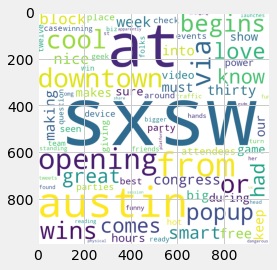

In [1360]:
wc = WordCloud(background_color="white",width=1000,height=1000, max_words=100,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(apple_poz_freq)
plt.imshow(wc)

In [1342]:
top_25_poz_google_words.sort_values(by='Frequency',ascending=False).head(50)

Word   Frequency
1    sxsw        106.263288
4    at          36.171394 
8    party       19.906759 
17   marissa     10.228082 
20   great       9.277255  
26   from        7.235406  
48   fun         4.445248  
65   physical    3.718549  
80   free        3.156449  
81   austin      3.139594  
85   gsdm        2.917089  
88   big         2.833526  
95   cool        2.601925  
103  via         2.441030  
106  love        2.354842  
114  tweets      2.298433  
118  session     2.212501  
119  best        2.211262  
142  check       1.909790  
144  others      1.855150  
152  our         1.784358  
164  traffic     1.606911  
175  game        1.484186  
182  win         1.405075  
184  around      1.388068  
201  her         1.279203  
251  week        1.062639  
255  team        1.048598  
256  or          1.036986  
271  making      0.948680  
281  event       0.919970  
283  saw         0.914878  
322  launching   0.766398  
327  nice        0.761162  
343  sure        0.721181  
358  smart       0.695568  
359  had         0.689829  
364  keep        0.688018  
366  into        0.685702  
382  know        0.662323  
387  thirty      0.656148  
389  twelve      0.655025  
415  place       0.614514  
424  share       0.600698  
447  apparently  0.557252  
479  hot         0.508199  
498  video       0.493901  
500  comes       0.492536  
516  show        0.481474  
537  friends     0.471405

In [1312]:
google_words.sort_values(by=['Negative_Probability','Frequency'],ascending=False).head(50)

Word  Frequency  \
2233  headaches      0.000000    
262   fail           1.005735    
1701  sucks          0.000000    
8705  faulty         0.000000    
1651  hate           0.000000    
4868  lame           0.000000    
4385  deleting       0.000000    
1825  fades          0.000000    
1452  fuck           0.196116    
1904  stupid         0.000000    
4419  ridic          0.000000    
5300  crashes        0.000000    
647   seems          0.427731    
1837  battery        0.000000    
7875  conflagration  0.000000    
7876  doofusness     0.000000    
2724  fascist        0.000000    
836   concept        0.277350    
249   because        1.074016    
1201  hand           0.218218    
3530  compatible     0.000000    
2587  mad            0.000000    
6339  stuck          0.000000    
259   needs          1.021132    
5881  hm             0.000000    
323   issues         0.764889    
691   point          0.407200    
2051  insane         0.000000    
899   shit           0.258199    
239   another        1.110591    
2280  trouble        0.000000    
2832  synching       0.000000    
215   cannot         1.220550    
2481  socialviewing  0.000000    
1698  suck           0.000000    
1717  panhandling    0.000000    
631   enough         0.438652    
991   terrible       0.242536    
1737  fucking        0.000000    
4491  sigh           0.000000    
1734  aapl           0.000000    
1887  button         0.000000    
2639  worst          0.000000    
3041  stream         0.000000    
273   innovation     0.945558    
407   long           0.631818    
1102  smm            0.229416    
875   under          0.267261    
2742  hmm            0.000000    
3758  epic           0.000000    

                                         Probability  Positive_Probability  \
2233  [[1.3728745066332593e-06, 0.9999986271254934]]  0.000001               
262   [[2.3570532864392035e-06, 0.9999976429467136]]  0.000002               
1701  [[4.0562915190056614e-06, 0.999995943708481]]   0.000004               
8705  [[1.0922783009292836e-05, 0.9999890772169907]]  0.000011               
1651  [[1.572625496015778e-05, 0.9999842737450398]]   0.000016               
4868  [[1.6096596189174583e-05, 0.9999839034038108]]  0.000016               
4385  [[1.700562330897437e-05, 0.999982994376691]]    0.000017               
1825  [[2.8301494757965173e-05, 0.999971698505242]]   0.000028               
1452  [[3.570977306410761e-05, 0.9999642902269359]]   0.000036               
1904  [[3.813141157471556e-05, 0.9999618685884253]]   0.000038               
4419  [[3.8296517428371146e-05, 0.9999617034825716]]  0.000038               
5300  [[4.5057290616656864e-05, 0.9999549427093833]]  0.000045               
647   [[4.667096400201576e-05, 0.999953329035998]]    0.000047               
1837  [[7.818355495570195e-05, 0.9999218164450443]]   0.000078               
7875  [[8.214230427094904e-05, 0.999917857695729]]    0.000082               
7876  [[8.214230427094904e-05, 0.999917857695729]]    0.000082               
2724  [[0.00010467181793627489, 0.9998953281820637]]  0.000105               
836   [[0.00010841406184514124, 0.9998915859381549]]  0.000108               
249   [[0.00012596316920576722, 0.9998740368307942]]  0.000126               
1201  [[0.00013956822731286955, 0.9998604317726871]]  0.000140               
3530  [[0.00014020229279787522, 0.9998597977072021]]  0.000140               
2587  [[0.00014160545333796737, 0.999858394546662]]   0.000142               
6339  [[0.00014260807497556982, 0.9998573919250244]]  0.000143               
259   [[0.00014655898709703408, 0.999853441012903]]   0.000147               
5881  [[0.000147126688379573, 0.9998528733116204]]    0.000147               
323   [[0.00016631281390555586, 0.9998336871860944]]  0.000166               
691   [[0.00017816402006443077, 0.9998218359799356]]  0.000178               
2051  [[0.00017939734035765653, 0.9998206026596423]]  0.000179               
899   [[0.00020050

In [1311]:
apple_words.sort_values(by=['Negative_Probability','Frequency'],ascending=False).head(50)

Word  Frequency  \
2218  headaches      0.258199    
282   fail           3.326161    
173   sucks          6.078211    
2025  faulty         0.288675    
113   hate           9.537062    
1593  lame           0.423607    
629   deleting       1.294187    
1273  fades          0.544611    
32    fuck           34.512568   
250   stupid         3.772232    
1776  ridic          0.353553    
1382  crashes        0.492536    
287   seems          3.257956    
129   battery        8.422517    
8119  conflagration  0.000000    
8120  doofusness     0.000000    
229   fascist        4.039112    
905   concept        0.834046    
72    because        15.827223   
1194  hand           0.595012    
4754  compatible     0.000000    
678   mad            1.194620    
1935  stuck          0.301511    
318   needs          2.900193    
6539  hm             0.000000    
437   issues         2.053581    
425   point          2.105773    
1337  insane         0.506766    
51    shit           23.344062   
240   another        3.938421    
961   trouble        0.778663    
2052  synching       0.277350    
82    cannot         14.557229   
4003  socialviewing  0.000000    
159   suck           6.572113    
3533  panhandling    0.000000    
581   enough         1.432128    
550   terrible       1.512323    
89    fucking        12.787909   
844   sigh           0.916822    
25    aapl           38.362209   
938   button         0.801162    
432   worst          2.075381    
1149  stream         0.629656    
513   innovation     1.633869    
169   long           6.135235    
4207  smm            0.000000    
1231  under          0.572893    
1905  hmm            0.301511    
4918  epic           0.000000    

                                         Probability  Positive_Probability  \
2218  [[1.3728745066332593e-06, 0.9999986271254934]]  0.000001               
282   [[2.3570532864392035e-06, 0.9999976429467136]]  0.000002               
173   [[4.0562915190056614e-06, 0.999995943708481]]   0.000004               
2025  [[1.0922783009292836e-05, 0.9999890772169907]]  0.000011               
113   [[1.572625496015778e-05, 0.9999842737450398]]   0.000016               
1593  [[1.6096596189174583e-05, 0.9999839034038108]]  0.000016               
629   [[1.700562330897437e-05, 0.999982994376691]]    0.000017               
1273  [[2.8301494757965173e-05, 0.999971698505242]]   0.000028               
32    [[3.570977306410761e-05, 0.9999642902269359]]   0.000036               
250   [[3.813141157471556e-05, 0.9999618685884253]]   0.000038               
1776  [[3.8296517428371146e-05, 0.9999617034825716]]  0.000038               
1382  [[4.5057290616656864e-05, 0.9999549427093833]]  0.000045               
287   [[4.667096400201576e-05, 0.999953329035998]]    0.000047               
129   [[7.818355495570195e-05, 0.9999218164450443]]   0.000078               
8119  [[8.214230427094904e-05, 0.999917857695729]]    0.000082               
8120  [[8.214230427094904e-05, 0.999917857695729]]    0.000082               
229   [[0.00010467181793627489, 0.9998953281820637]]  0.000105               
905   [[0.00010841406184514124, 0.9998915859381549]]  0.000108               
72    [[0.00012596316920576722, 0.9998740368307942]]  0.000126               
1194  [[0.00013956822731286955, 0.9998604317726871]]  0.000140               
4754  [[0.00014020229279787522, 0.9998597977072021]]  0.000140               
678   [[0.00014160545333796737, 0.999858394546662]]   0.000142               
1935  [[0.00014260807497556982, 0.9998573919250244]]  0.000143               
318   [[0.00014655898709703408, 0.999853441012903]]   0.000147               
6539  [[0.000147126688379573, 0.9998528733116204]]    0.000147               
437   [[0.00016631281390555586, 0.9998336871860944]]  0.000166               
425   [[0.00017816402006443077, 0.9998218359799356]]  0.000178               
1337  [[0.00017939734035765653, 0.9998206026596423]]  0.000179               
51    [[0.00020050

In [1308]:
google_words.sort_values(by=['Positive_Probability','Frequency'],ascending=False).head(20)

Word   Frequency                                    Probability  \
1     sxsw      106.263288  [[0.9999988986337257, 1.101366274272545e-06]]   
80    free      3.156449    [[0.8417610232027308, 0.1582389767972692]]      
821   downtown  0.277350    [[0.8358240537068551, 0.16417594629314486]]     
8     party     19.906759   [[0.7990583330755664, 0.20094166692443358]]     
106   love      2.354842    [[0.7131641681494094, 0.28683583185059064]]     
1150  giving    0.223607    [[0.7037267489173122, 0.2962732510826877]]      
1662  popup     0.000000    [[0.6923105162289751, 0.30768948377102484]]     
152   our       1.784358    [[0.678564928154922, 0.321435071845078]]        
498   video     0.493901    [[0.6281436959663476, 0.3718563040336524]]      
184   around    1.388068    [[0.6019112621511363, 0.39808873784886367]]     
182   win       1.405075    [[0.5836852543789268, 0.4163147456210731]]      
1315  congress  0.208514    [[0.5676863792646902, 0.4323136207353098]]      
1690  case      0.000000    [[0.5662178827319159, 0.43378211726808413]]     
251   week      1.062639    [[0.5519048867966445, 0.4480951132033555]]      
1200  winning   0.218218    [[0.5410601790652569, 0.45893982093474306]]     
1623  opening   0.000000    [[0.5345091575430483, 0.46549084245695166]]     
201   her       1.279203    [[0.5294199920204918, 0.47058000797950816]]     
1322  parties   0.208514    [[0.5275217020002138, 0.47247829799978625]]     
255   team      1.048598    [[0.5215832279184316, 0.47841677208156846]]     
26    from      7.235406    [[0.5066052150944668, 0.49339478490553323]]     

      Positive_Probability  Negative_Probability  
1     0.999999              0.000001              
80    0.841761              0.158239              
821   0.835824              0.164176              
8     0.799058              0.200942              
106   0.713164              0.286836              
1150  0.703727              0.296273              
1662  0.692311              0.307689              
152   0.678565              0.321435              
498   0.628144              0.371856              
184   0.601911              0.398089              
182   0.583685              0.416315              
1315  0.567686              0.432314              
1690  0.566218              0.433782              
251   0.551905              0.448095              
1200  0.541060              0.458940              
1623  0.534509              0.465491              
201   0.529420              0.470580              
1322  0.527522              0.472478              
255   0.521583              0.478417              
26    0.506605              0.493395

In [1305]:
apple_words.sort_values(by=['Positive_Probability','Frequency'],ascending=False).head(20)

Word   Frequency                                    Probability  \
2     sxsw      174.495403  [[0.9999988986337257, 1.101366274272545e-06]]   
261   free      3.621176    [[0.8417610232027308, 0.1582389767972692]]      
80    downtown  14.730692   [[0.8358240537068551, 0.16417594629314486]]     
515   party     1.631222    [[0.7990583330755664, 0.20094166692443358]]     
109   love      10.033695   [[0.7131641681494094, 0.28683583185059064]]     
548   giving    1.516198    [[0.7037267489173122, 0.2962732510826877]]      
99    popup     11.018140   [[0.6923105162289751, 0.30768948377102484]]     
311   our       2.974499    [[0.678564928154922, 0.321435071845078]]        
418   video     2.136012    [[0.6281436959663476, 0.3718563040336524]]      
634   around    1.277927    [[0.6019112621511363, 0.39808873784886367]]     
848   win       0.913624    [[0.5836852543789268, 0.4163147456210731]]      
234   congress  3.999111    [[0.5676863792646902, 0.4323136207353098]]      
760   case      1.041484    [[0.5662178827319159, 0.43378211726808413]]     
217   week      4.200094    [[0.5519048867966445, 0.4480951132033555]]      
897   winning   0.847439    [[0.5410601790652569, 0.45893982093474306]]     
60    opening   17.324827   [[0.5345091575430483, 0.46549084245695166]]     
1625  her       0.409317    [[0.5294199920204918, 0.47058000797950816]]     
544   parties   1.523914    [[0.5275217020002138, 0.47247829799978625]]     
816   team      0.967378    [[0.5215832279184316, 0.47841677208156846]]     
57    from      18.240830   [[0.5066052150944668, 0.49339478490553323]]     

      Positive_Probability  Negative_Probability  
2     0.999999              0.000001              
261   0.841761              0.158239              
80    0.835824              0.164176              
515   0.799058              0.200942              
109   0.713164              0.286836              
548   0.703727              0.296273              
99    0.692311              0.307689              
311   0.678565              0.321435              
418   0.628144              0.371856              
634   0.601911              0.398089              
848   0.583685              0.416315              
234   0.567686              0.432314              
760   0.566218              0.433782              
217   0.551905              0.448095              
897   0.541060              0.458940              
60    0.534509              0.465491              
1625  0.529420              0.470580              
544   0.527522              0.472478              
816   0.521583              0.478417              
57    0.506605              0.493395

In [1252]:
google_words['Positive_Probability']=google_words['Probability'].map(lambda x: x[0][0])
google_words['Negative_Probability']=google_words['Probability'].map(lambda x: x[0][1])

In [1287]:
apple_poz_words = apple_words.sort_values(by='Positive_Probability',ascending=False)['Word'][0:200]
apple_neg_words = apple_words.sort_values(by='Negative_Probability',ascending=False)['Word'][0:200]

In [1289]:
apple_neg_words

2218    headaches
282     fail     
173     sucks    
2025    faulty   
113     hate     
        ...      
1628    failing  
5581    facing   
283     world    
7022    nerdiest 
703     okay     
Name: Word, Length: 200, dtype: object

In [1288]:
apple_poz_words

2       sxsw     
261     free     
80      downtown 
515     party    
109     love     
        ...      
4098    interview
4028    cases    
518     person   
4402    mophie   
2481    earth    
Name: Word, Length: 200, dtype: object

In [1259]:
google_poz_words = google_words.sort_values(by='Positive_Probability',ascending=False)['Word'][0:200]

In [1264]:
google_neg_words = google_words.sort_values(by='Negative_Probability',ascending=False)['Word'][0:200]

In [1273]:
sample_text = ' '.join(google_neg_words)

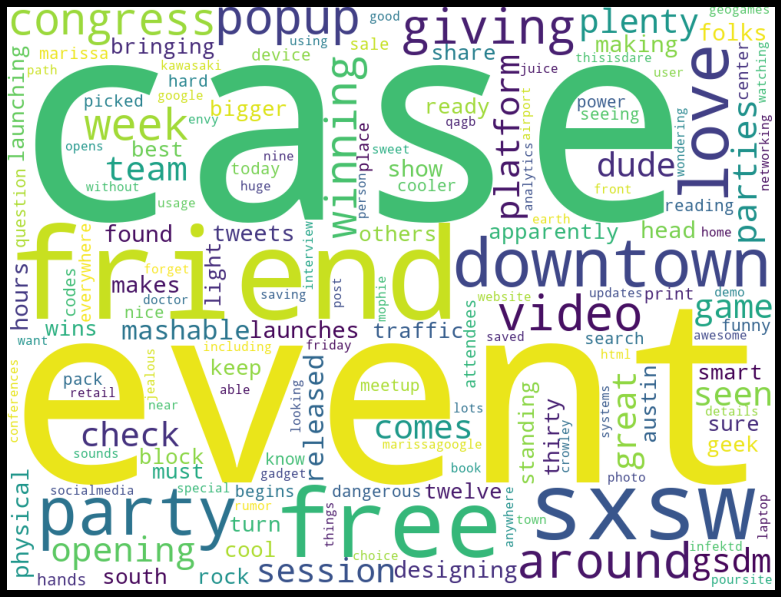

In [1500]:
# sample_text = ' '.join(coef_df[coef_df['value']>0]['feature'])
wordcloud = WordCloud(min_word_length=4,max_words=200,width=1000, height=760, background_color="white",collocations=True).generate(sample_text)

# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

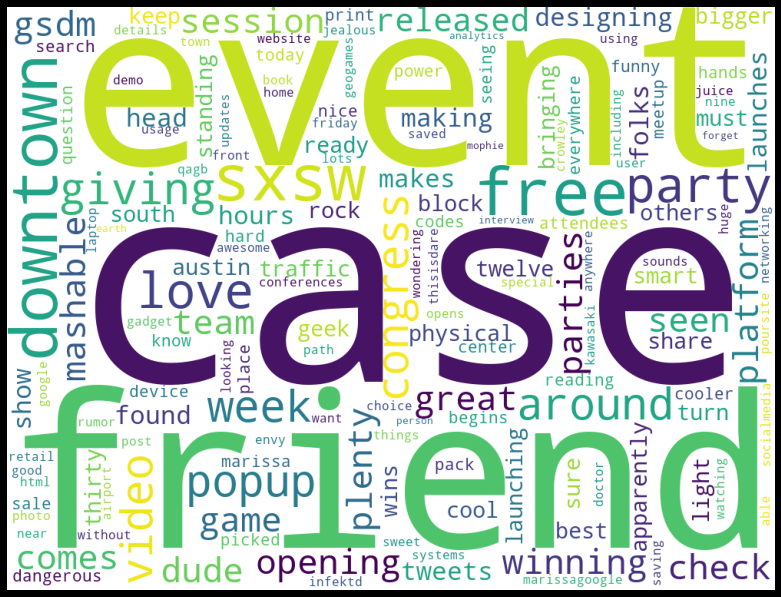

In [1499]:
sample_text = ' '.join(google_poz_words)
wordcloud = WordCloud(min_word_length=4,max_words=200,width=1000, height=760, background_color="white",collocations=True).generate(sample_text)

# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [1277]:
bag_of_words = vectorizer.transform(new_df[new_df['Product']=='Apple']['processed_text'])
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in     vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
google_words_freq = words_freq

In [1197]:
LG_GS_Neg.predict_proba(['suck'])

array([[2.64484005e-04, 9.99735516e-01]])

In [1192]:
def get_top_n_words(corpus, n=None):
    vec = TfidfVectorizer(ngram_range=(1,1),use_idf=False,max_df=.9).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [1121]:
apple_corpus = [''.join(new_df[new_df['Product']=='Apple']['processed_text'].apply(lambda x: ','.join([str(i) for i in x])))]


In [1151]:
new_df[new_df['processed_text'].str.contains('fail')]['Product'].value_counts()

Apple                              18
iPad                               7 
Google                             5 
iPhone                             4 
Android                            3 
iPad or iPhone App                 3 
Other Google product or service    2 
Android App                        2 
Name: Product, dtype: int64

In [1209]:
LG_GS_Neg.classes_

array([0, 1], dtype=uint8)

In [1214]:
LG_GS_Neg.predict_proba(['fascist'])

array([[1.04671818e-04, 9.99895328e-01]])

In [1165]:
new_df['Product'].value_counts(normalize=True)

Apple                              0.417241
iPad                               0.209287
iPad or iPhone App                 0.104421
Google                             0.095312
iPhone                             0.065763
Other Google product or service    0.064874
Android App                        0.017996
Android                            0.017329
Other Apple product or service     0.007776
Name: Product, dtype: float64

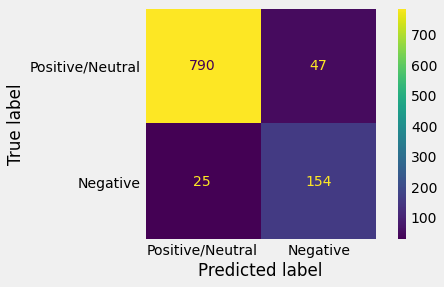

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       837
           1       0.77      0.86      0.81       179

    accuracy                           0.93      1016
   macro avg       0.87      0.90      0.88      1016
weighted avg       0.93      0.93      0.93      1016



In [136]:
fn.reporting(LG_GS_Neg,X_test,y_test)

In [141]:
test_preds = LG_GS_Neg.predict(X_test)

In [146]:
fn.accuracy_score(y_test,test_preds)

0.9291338582677166

In [153]:
new_df[new_df['processed_text'].str.contains('party')]['processed_text']

24       RT : I am looking forward to the #SMCDallas pr...
71       Do it. RT  Come party w/ Google tonight at #sx...
74       Holla! RT  At google party. Best ever! Get you...
86                 Thank you  for an awesome #sxsw party! 
165      Monday at #sxsw: barry diller, new york times,...
                               ...                        
8828     At a party being thrown by Google and the aclu...
8839     Bing party in the same location as last year's...
8867     Come party w/  and Google tonight at #sxsw:  B...
8911      you will be at the google party tonight? Goin...
10004      too bad all third party keyboards on iOS are...
Name: processed_text, Length: 278, dtype: object